# pre

## import & setting

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import seaborn as sns
import palettable
import pandas as pd
import scipy.io as sio
sc.set_figure_params(dpi=500, color_map='viridis')
sc.settings.verbosity = 2
%matplotlib inline


## functions

In [2]:
def ind2ij(ind,size,axis):
    i,j=divmod(ind-1,size)
    i+=1
    j+=1
    return np.array([i,j])[axis]



In [3]:
def get_train_data(data_mat_filename,mode,norm,batch_num_list=[1]):
#     mode分为:'none','median','total'
#     norm分为:'none',standard','l1','l2'
#     batch_num_list = [3,5]
    # 5行
    # 1,2,3,4,5,6
    # batch_num = 4


    original_data = {}
    cell_related_data = {}
    data_mat = sio.loadmat(data_mat_filename)
    data_mat=data_mat['data_mat']



    num_features = data_mat.shape[1]-3
    batch_dict = {}

    label_dict = {}
    cell_dict = {}
    pos_dict = {}

    for i in range(1):

            cur_data = data_mat[data_mat[:,0]==i+1,3:num_features+3]


            batch_dict[i+1] = cur_data

            cell_dict[i+1] = data_mat[data_mat[:,0]==i+1,1]
            cur_batch_idx = data_mat[data_mat[:,0]==i+1,2]
            label_dict[i+1] = np.ones(shape=cur_batch_idx.shape)


            pos_dict[i+1] = cur_batch_idx
    original_data['batch_dict'] = batch_dict
    original_data['cell_dict'] = cell_dict
    original_data['label_dict'] = label_dict
    original_data['pos_dict'] = pos_dict






    top_n_var = 250
    train_x_all = None
    cell_idx_all = None
    cell_type_all = None
    cell_pos_all = None
    batch_idx_all = None
    num_cells_all = 0


    for batch_num in batch_num_list:
        train_x = batch_dict[batch_num]
        # train_x = eval('batch_dict_{norm_type}[batch_num]'.format(norm_type=norm_type))
        # train_x = batch_dict[batch_num]
        cell_idx = cell_dict[batch_num]
        cell_type = label_dict[batch_num]
        cell_pos = pos_dict[batch_num]
        # batch_FE = FE_dict[batch_num]
        cell_related_ind = (cell_idx!=0)

        num_cells = int(np.max(cell_idx))
        # num_cells = 2
        train_x = train_x[cell_related_ind,:]

        cell_idx = cell_idx[cell_related_ind]
        cell_type = cell_type[cell_related_ind]
        # cell_type = np.ones(shape=cell_idx.shape)
        cell_pos = cell_pos[cell_related_ind]





        var_li = []
        normed_var_li = []
        for i in range(train_x.shape[1]):
            cur_col = train_x[:,i]
        #     cur_col= cur_row/np.sum(cur_col)
        #     cur_entropy = entropy(cur_col)
            cur_var = np.var(cur_col)
            cur_normed_var = cur_var/np.mean(cur_col)
        #     entropy_li.append(cur_entropy)
            var_li.append(cur_var)
            normed_var_li.append(cur_normed_var)
        # entropy_li = np.array(entropy_li)
        var_li = np.array(var_li)
        normed_var_li = np.array(normed_var_li)
        sort_ind = np.flip(np.argsort(normed_var_li),axis=0)
        sort_val = np.flip(np.sort(normed_var_li),axis=0)
        
        if train_x_all is None:
            train_x_all = train_x
        else:
            train_x_all = np.vstack([train_x_all,train_x])
        if cell_idx_all is None:
            cell_idx_all = cell_idx
        else:
            cell_idx_all = np.hstack([cell_idx_all,cell_idx+np.max(cell_idx_all)])
        if cell_type_all is None:
            cell_type_all = cell_type
        else:
            cell_type_all = np.hstack([cell_type_all,cell_type])
        if cell_pos_all is None:
            cell_pos_all = cell_pos
        else:
            cell_pos_all = np.hstack([cell_pos_all,cell_pos])
        if batch_idx_all is None:
            batch_idx_all = batch_num*np.ones(shape=(cell_idx.shape))
        else:
            batch_idx_all = np.hstack([batch_idx_all,batch_num*np.ones(shape=(cell_idx.shape))])


    train_x = train_x_all
    cell_idx = cell_idx_all
    cell_type = cell_type_all
    cell_pos = cell_pos_all
    batch_idx = batch_idx_all
    num_cells = np.max(cell_idx)
    if mode=='none':
        train_x = train_x
    elif mode=='median':
        train_x = train_x/np.percentile(train_x,50,axis=1,keepdims=True)
        train_x = np.log(train_x+1)
    elif mode=='total':
        train_x = train_x/np.sum(train_x,axis=1,keepdims=True)
        train_x = np.log(train_x+1)

    if norm=='standard':
        train_x = StandardScaler().fit_transform(train_x)
    elif norm=='l1':
        train_x = Normalizer(norm='l1').fit_transform(train_x)
    elif norm=='l2':
        train_x = Normalizer(norm='l2').fit_transform(train_x)
    elif norm=='none':
        train_x = train_x

    cell_related_data['train_x'] = train_x
    cell_related_data['cell_idx'] = cell_idx
    cell_related_data['cell_type'] = cell_type
    cell_related_data['cell_pos'] = cell_pos
    cell_related_data['batch_idx'] =batch_idx
    cell_related_data['num_cells'] = num_cells
    return original_data,cell_related_data



In [4]:
def get_labeling(label,cell_idx,cell_pos):
#     y是cell-rela的细胞对应的标签
#     print('pred_y',np.unique(label))
    labeling = np.zeros(shape=(65536,1))
    b = cell_idx.copy()
    num_cells = label.shape[0]
    for i in range(num_cells):
        b[b==i+1] = label[i] + 1
#     print(cell_pos)
#     print('b',np.unique(b))
#     cell_pos = cell_pos.astype('int')
    labeling[cell_pos.astype('int')-1,0] = b

    return labeling

In [5]:
def show_images(images, cols = 1, titles = None,cmps='jet'):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
#         print(cols)
#         cmp = cmps[n]
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
#         if image.ndim == 2:
#             plt.gray()
        
    
        plt.imshow(image,cmap=cmps)
        plt.xticks([])
        plt.yticks([])
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    

import matplotlib.pyplot as plt
# uh_pred = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(rep_embed)
# pred_y = np.ones(shape=(np.max(cell_idx)))
# pred_y = KMeans(3).fit_predict(sim_mat_bak)
# pred_y = SIMLR(sim_mat_bak,-8)
# pred_y = SpectralClustering(4,affinity='precomputed').fit_predict(sim_mat_order_bak)
# pred_y = AgglomerativeClustering(4,affinity='precomputed',linkage='complete').fit_predict(1/(input_sim_mat+1))
def plot_label_image(pred_y,cmp,save=None,mask=None,figsize=(5,5),anno=False):
    
    to_labeling_pred_y = np.array(pred_y.astype('int'))
    to_labeling_pred_y_min = to_labeling_pred_y.min()
    # to_labeling_pred_y[coc[448,:]>0]=3
    # to_labeling_pred_y = resultsLWEA[:,2]
    # to_labeling_pred_y = label_list_FF[2]
    # to_labeling_pred_y = label_list[3]
    # to_labeling_pred_y[mark_list]=2
#     cluster_cmp = sns.hls_palette(np.unique(to_labeling_pred_y).shape[0])
    unique_cls = np.unique(pred_y).shape[0]
#     unique_cls_mask = [unique_cls[m] for m in mask]
    cluster_cmp = cmp.copy()
    
    if mask is not None:
        for to_mask in range(unique_cls):
            if to_mask in mask:
                continue
            cluster_cmp[to_mask]='k'
    labeling_plot_cmp = ['k']
    labeling_plot_cmp.extend(cluster_cmp)
    labeling = get_labeling(to_labeling_pred_y-np.min(to_labeling_pred_y),cell_idx,cell_pos)
    # labeling[labeling==5]=0
    img1 = labeling.reshape((256,256))
    plt.figure(figsize=figsize)
    # plt.imshow(img1)
    ticks=np.arange(np.min(img1)+1,np.max(img1)+1)
    boundaries = np.arange(np.min(img1)+0.5,np.max(img1)+1.5)
#     with sns.plotting_context(font_scale=font_scale):
    sns.heatmap(img1,cmap=labeling_plot_cmp,linewidths=0,linecolor='k',square=True,cbar_kws={"ticks":ticks, "boundaries":boundaries,'fraction':0.046,'pad':0.04})
    # sns.heatmap(img1,cmap=labeling_plot_cmp,square=True,ad':0.04})
#     plt.legend(fontsize=font_size)
    plt.xticks([])
    plt.yticks([])
    if save is not None:
        plt.savefig(save,transparent=False,format='pdf',bbox_inches='tight')

    if anno:
        num_cells = pred_y.shape[0]
        for i in range(num_cells):
            cur_idx = i + 1
            cur_ind = cell_pos[cell_idx==cur_idx][0]
        #     print(ind2ij(cur_ind,256,0))
        #     print(ind2ij(cur_ind,256,1))
            if to_labeling_pred_y[i]-to_labeling_pred_y_min in mask:
                plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')


    plt.show()


# experiment

## data loading

In [6]:
data_mat_filename_temp = '/home/yzy/bioSIMS/data/process/{0}/cut/rst/datamat.mat'
matter_list_filename_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/matters_candidate.pkl'


data='mouse0_liver0_neg1_high0_div15_None_ada'
test_sample_temp='/home/yzy/bioSIMS/data/process/{0}/preprocess/test_samples_244.mat'

matter_list_filename = matter_list_filename_temp.format(data)
data_mat_filename = data_mat_filename_temp.format(data)
test_sample_filename = test_sample_temp.format(data)
test_sample_all = sio.loadmat(test_sample_filename)['test_samples']
mode='none'
norm='none'
[original_data,cell_related_data]=get_train_data(data_mat_filename,mode,norm,batch_num_list=[1])
train_x=cell_related_data['train_x']
cell_idx=cell_related_data['cell_idx']
cell_pos=cell_related_data['cell_pos']

In [7]:
a = ad.read_h5ad('/home/yzy/ipynbs/figures/Fig2_dump_data/fig2_cluster5.h5ad')

In [8]:
a

AnnData object with n_obs × n_vars = 724 × 244 
    obs: 'pred'
    uns: 'dendrogram_pred', 'pred_colors', 'rank_genes_groups', 'rep_list'
    obsm: 'X_umap', 'X_pca'

In [10]:
cls_4 = np.array(a.obs['pred'])
cls_4[cls_4=='4']='2'
cls_4[cls_4=='5']='4'
a.obs['cls_4'] = cls_4

## umap projection

In [27]:
cmp_5 = palettable.colorbrewer.qualitative.Set1_5.mpl_colors
# 0:红
# 1:蓝
# 2:绿
# 3:紫
# 4:黄

In [28]:
cur_cmp = [cmp_5[3],cmp_5[1],cmp_5[2],cmp_5[0]]

In [141]:
cur_cmp

[(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

In [29]:
a.uns['cls_4_colors'] = cur_cmp

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

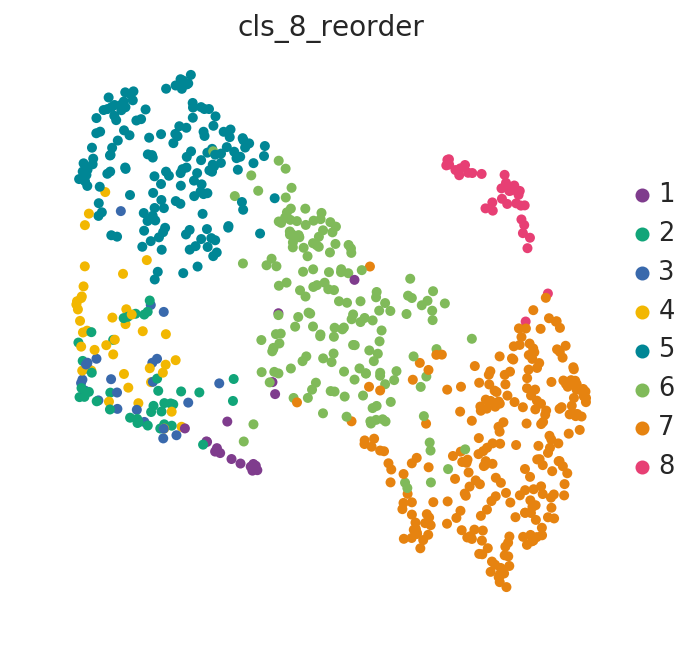

In [526]:
sc.settings.figdir = 'figures/Fig2/c8/'
save_umap = '_c8.pdf'
fig,ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(a,color=['cls_8_reorder'],ax=ax,save=save_umap,s=100,frameon=False)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

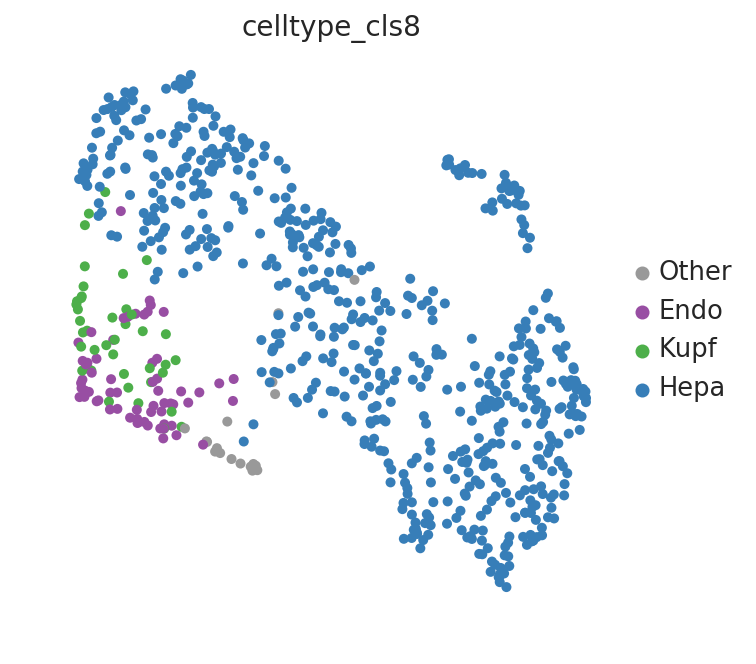

In [504]:
sc.settings.figdir = 'figures/Fig2/c8/'
save_umap = '_celltype_c8.pdf'
fig,ax = plt.subplots(1,1,figsize=(5,5))
sc.pl.umap(a,color=['celltype_cls8'],ax=ax,save=save_umap,s=100,frameon=False)


## visual cell typing

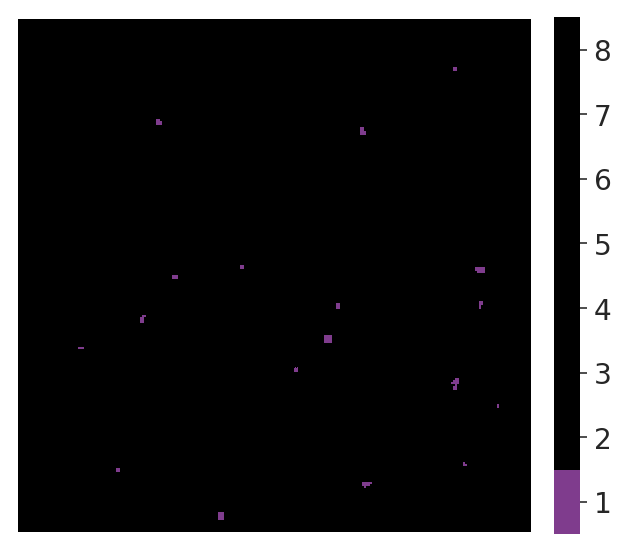

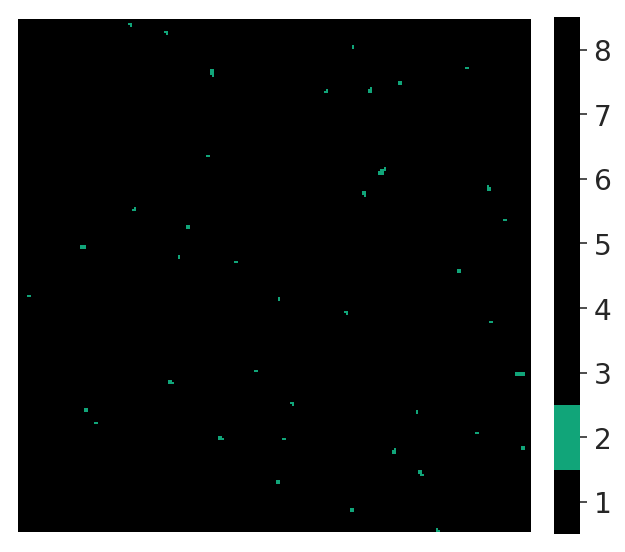

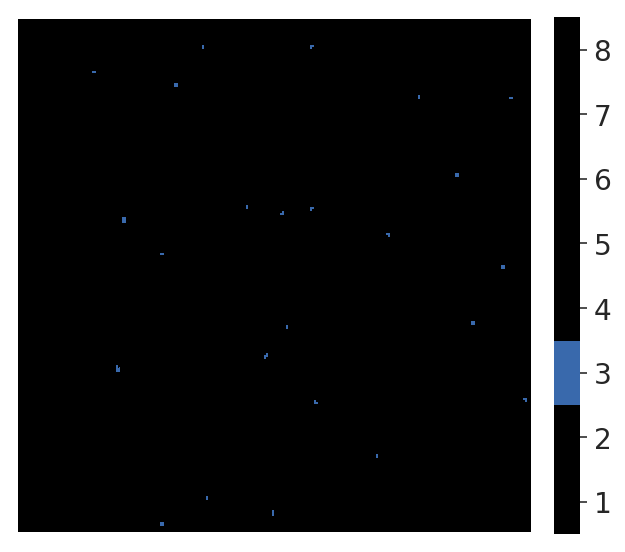

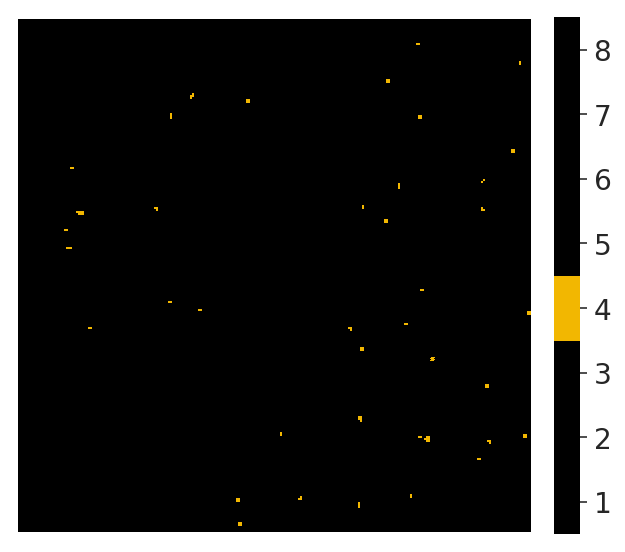

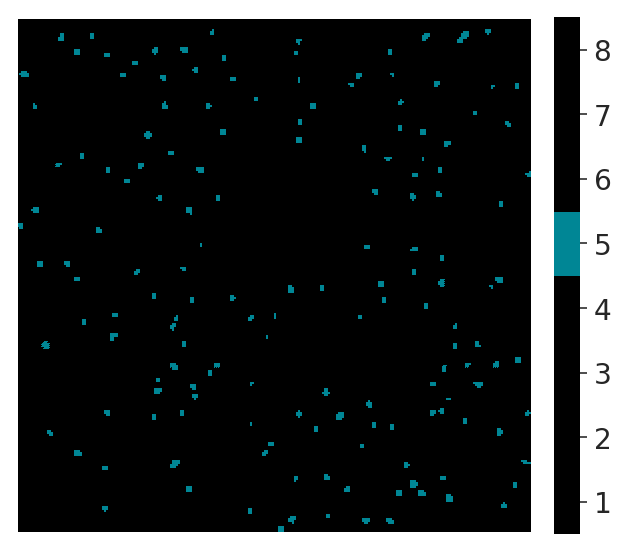

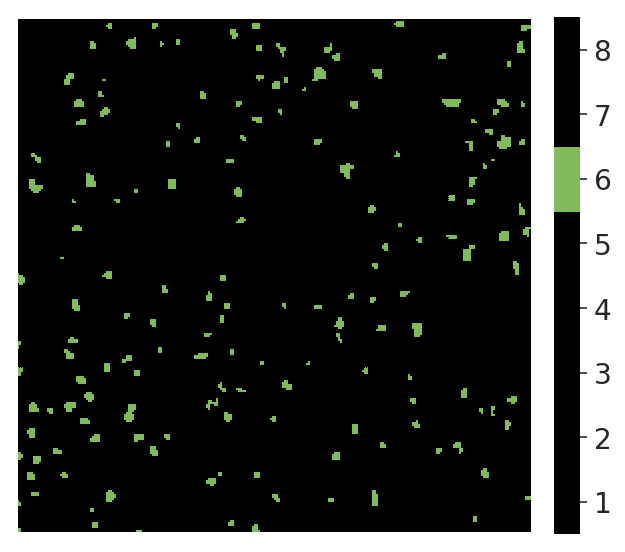

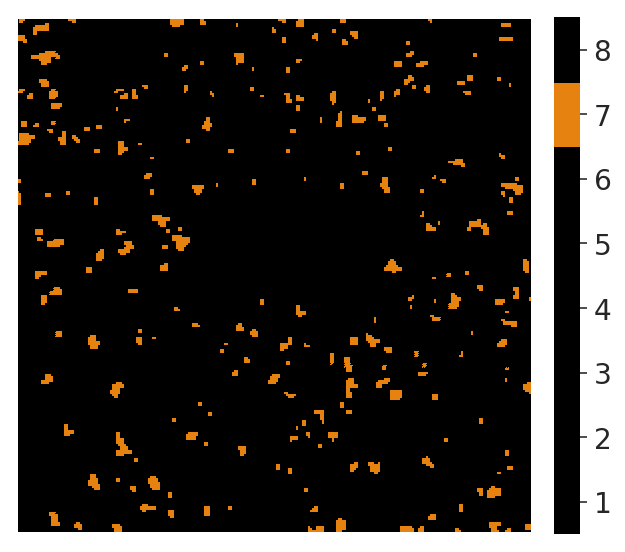

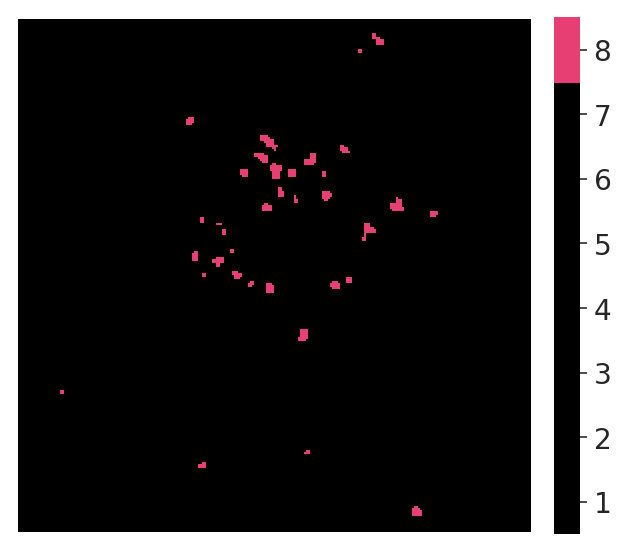

In [527]:
# 需要1～4；分别；4红其他白
save_cluster_image = '/home/yzy/ipynbs/figures/Fig2/c8/cluster_image/cluster_image_{0}_c8.pdf'

for i in range(8):
#     for j in range(2):
    cur_save = save_cluster_image.format(str(i))
    plot_label_image(a.obs['cls_8_reorder'],a.uns['cls_8_reorder_colors'],mask=[i],save=cur_save)
    


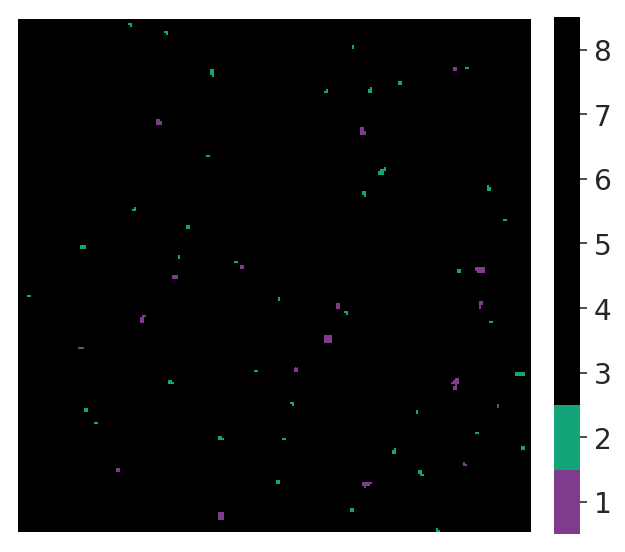

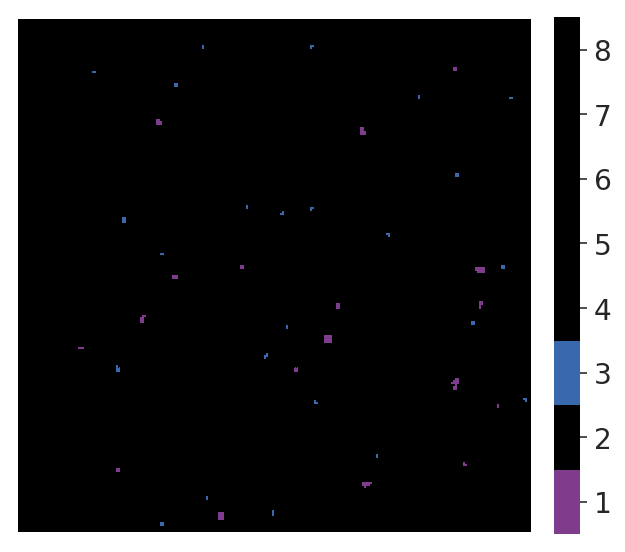

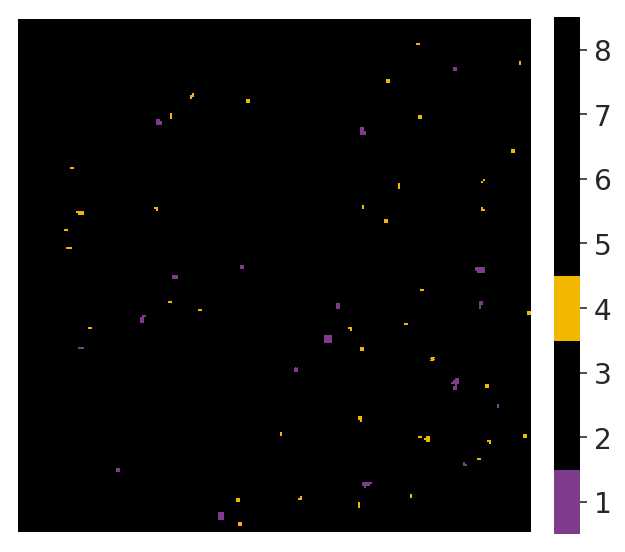

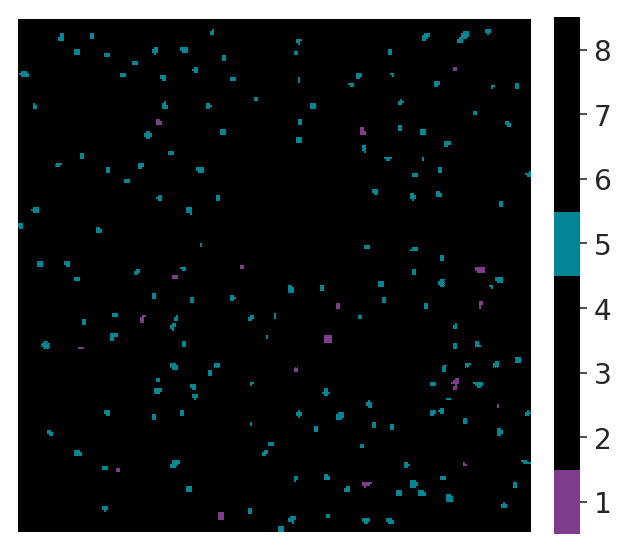

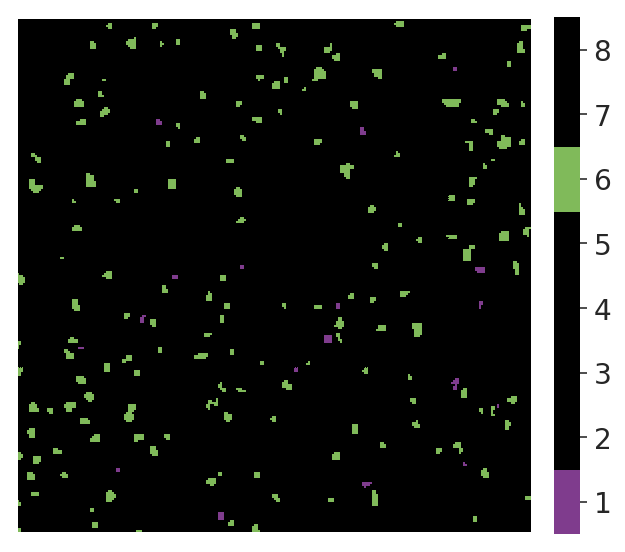

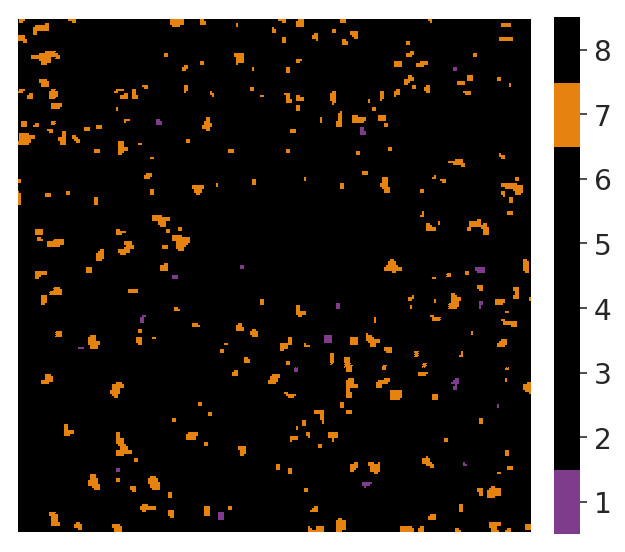

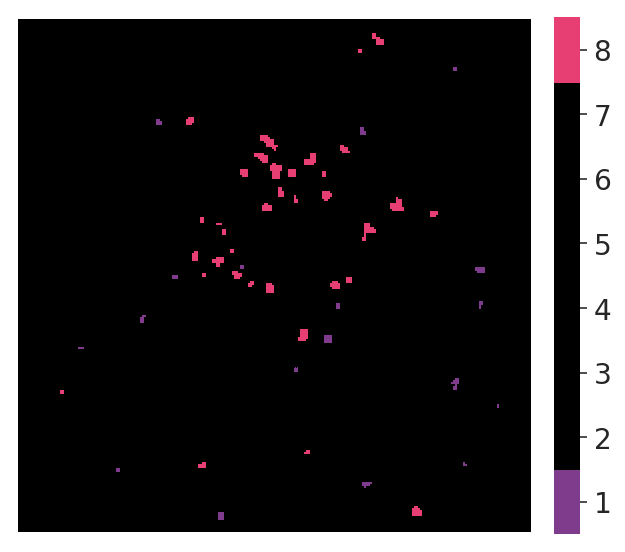

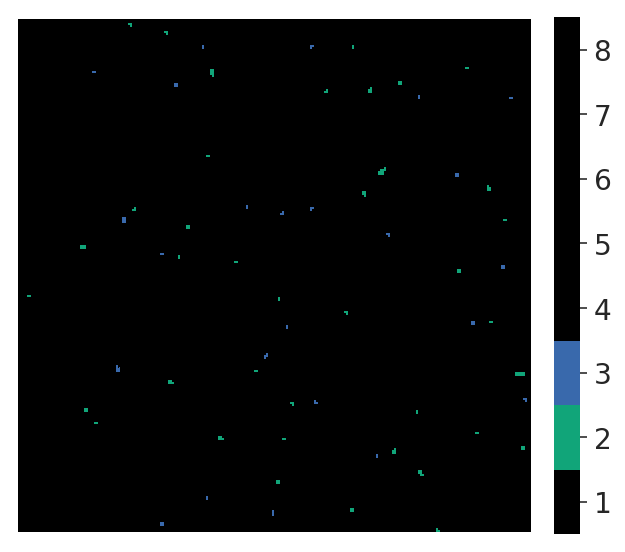

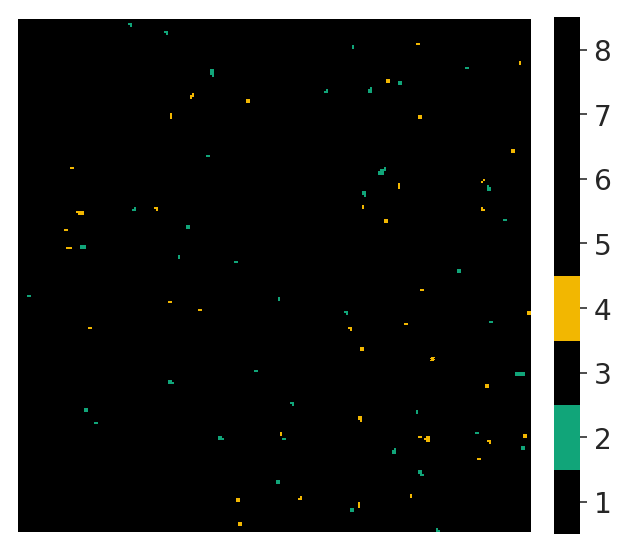

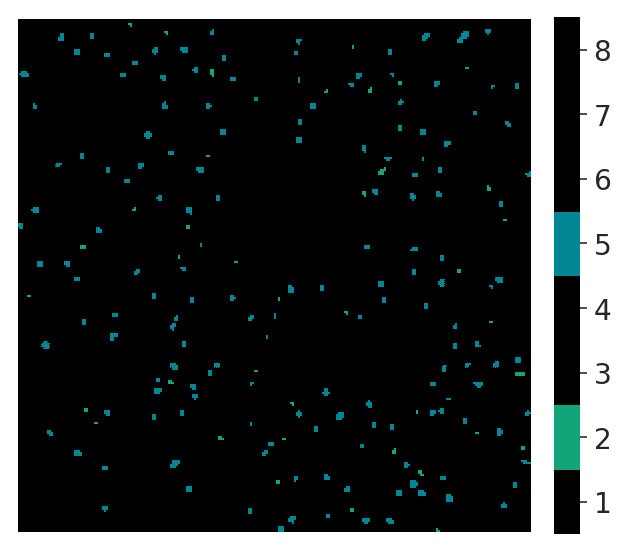

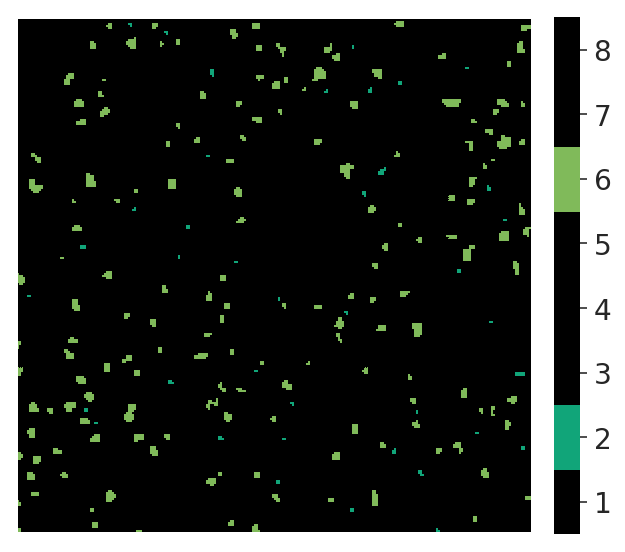

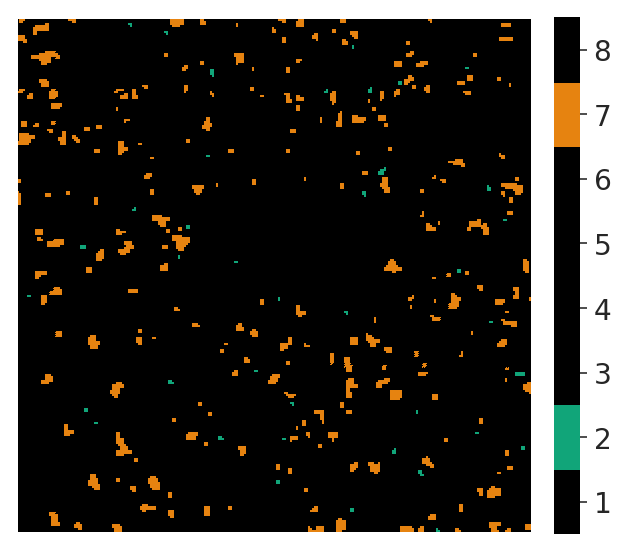

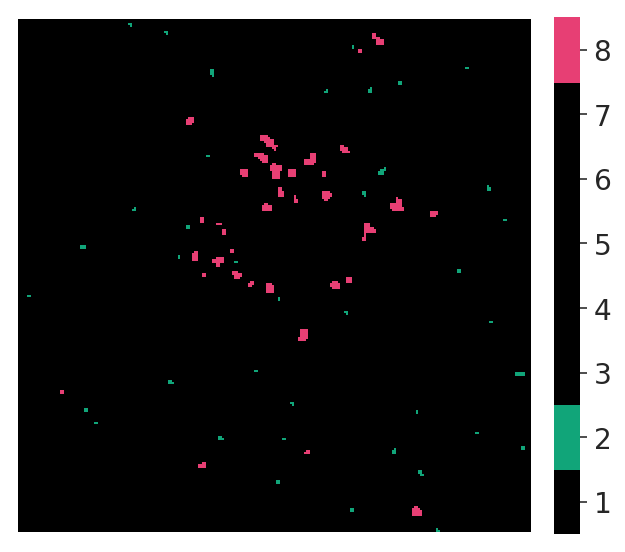

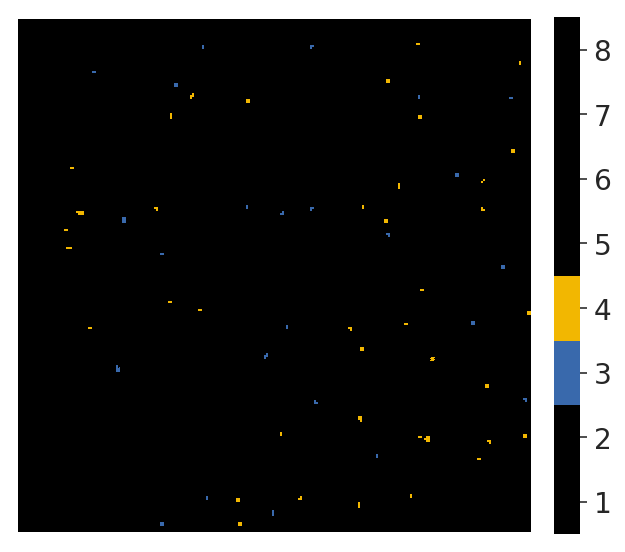

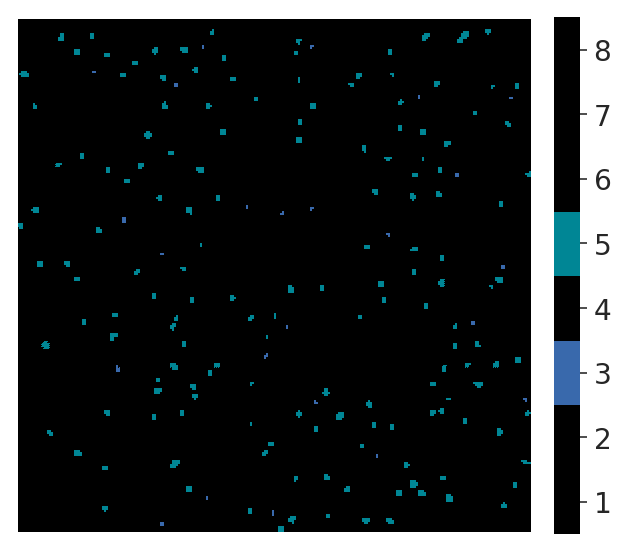

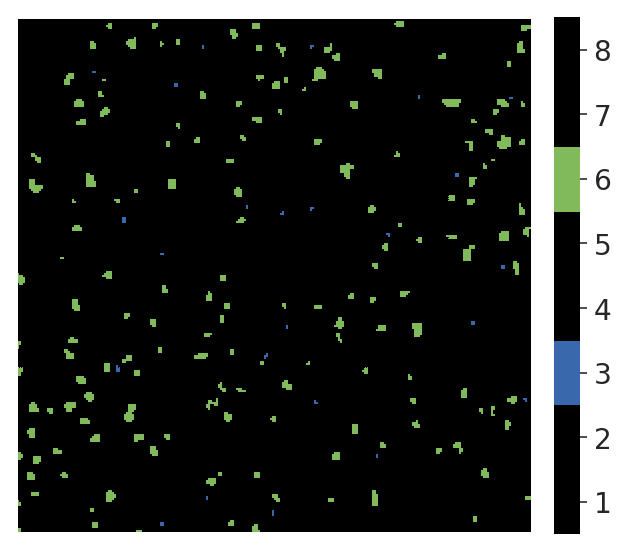

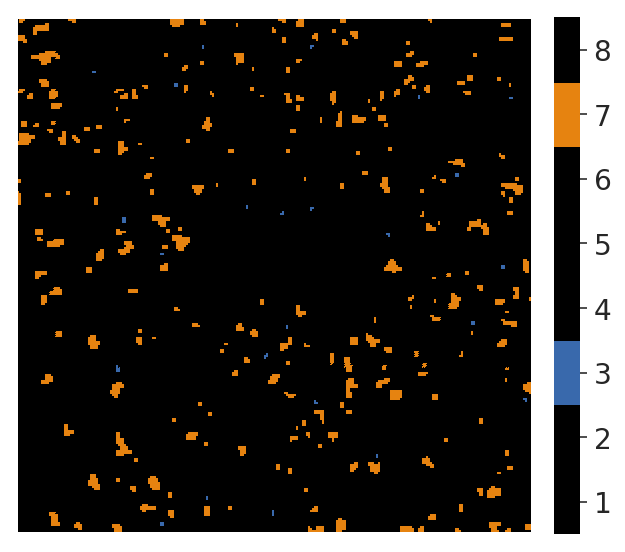

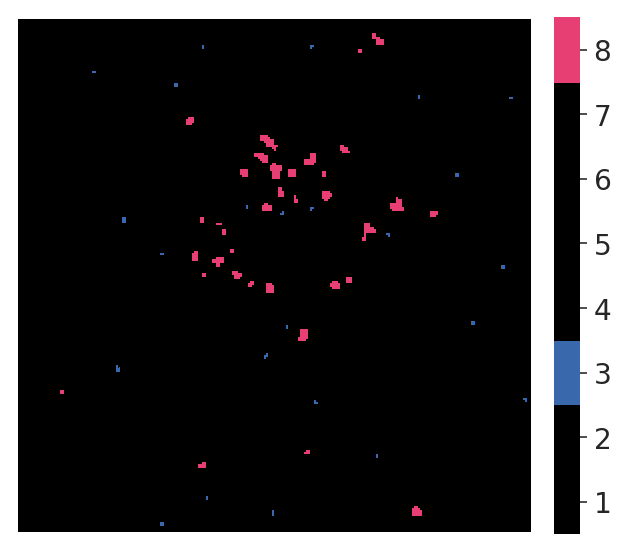

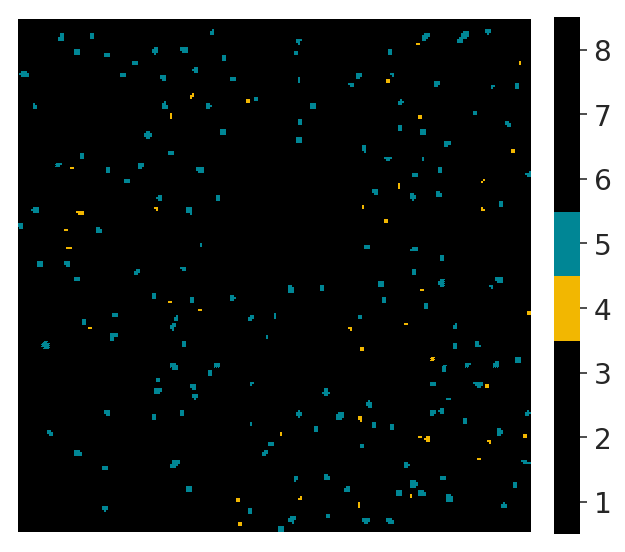

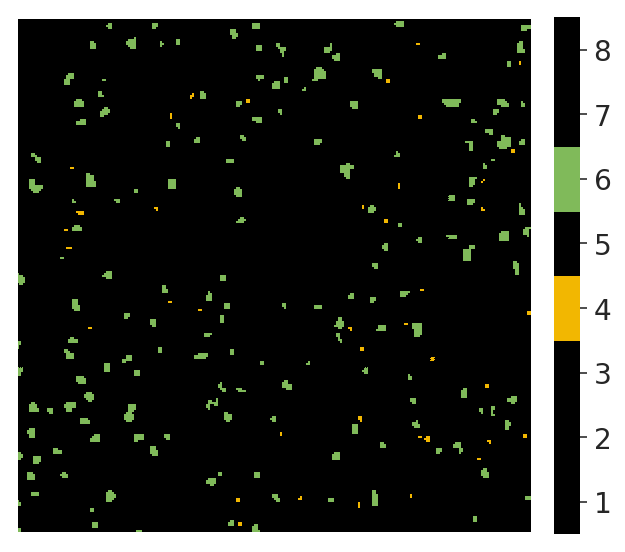

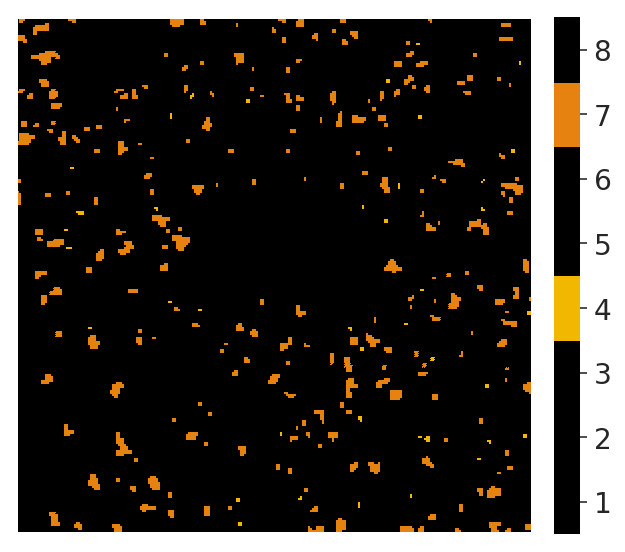

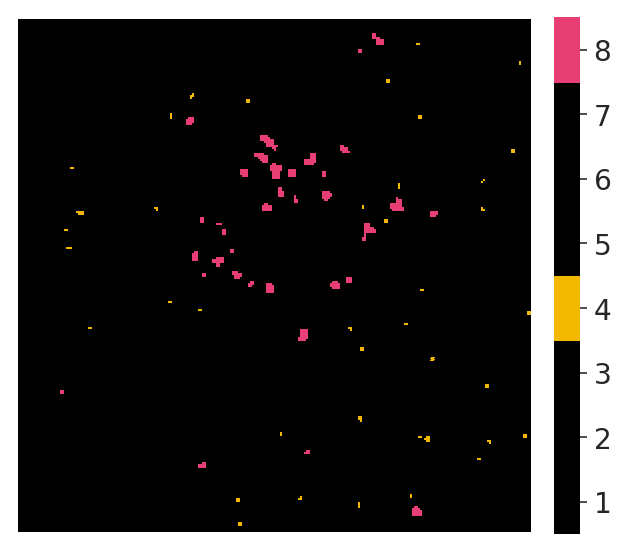

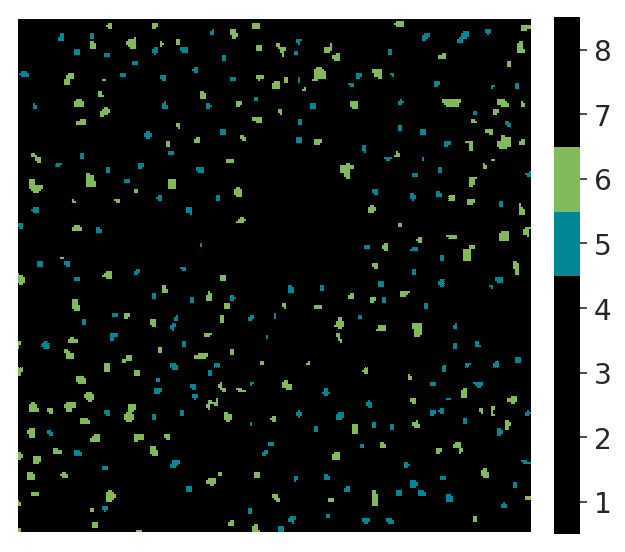

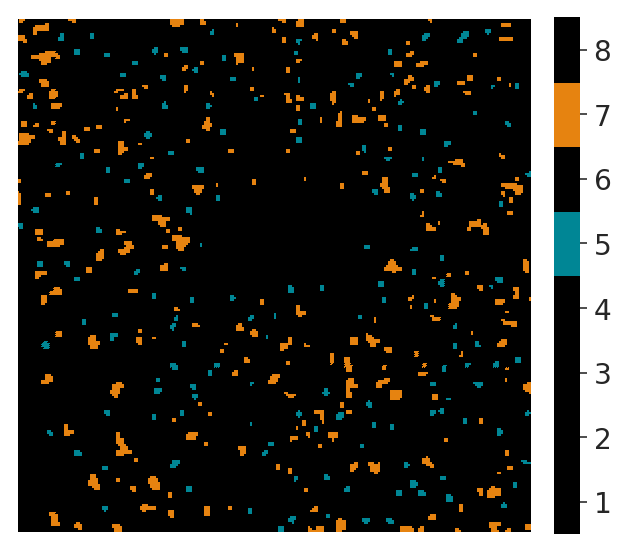

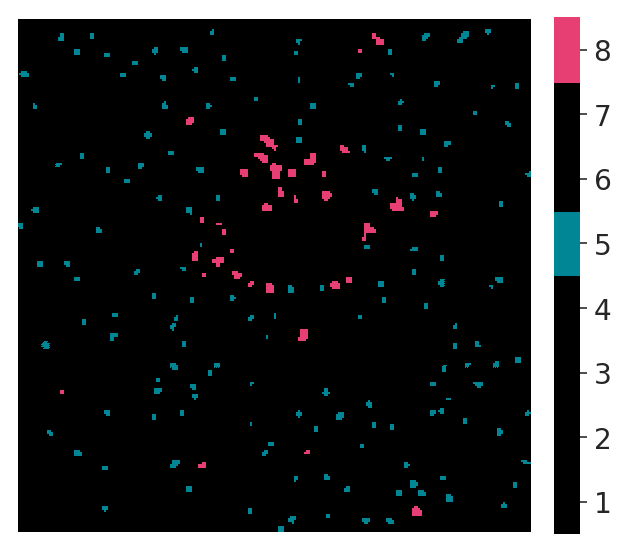

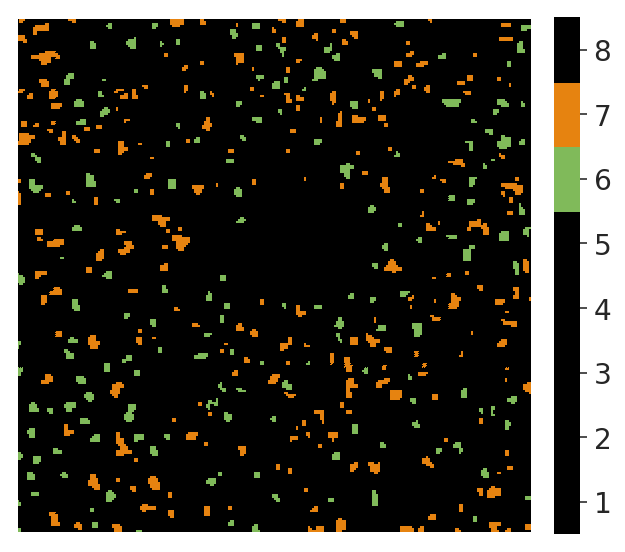

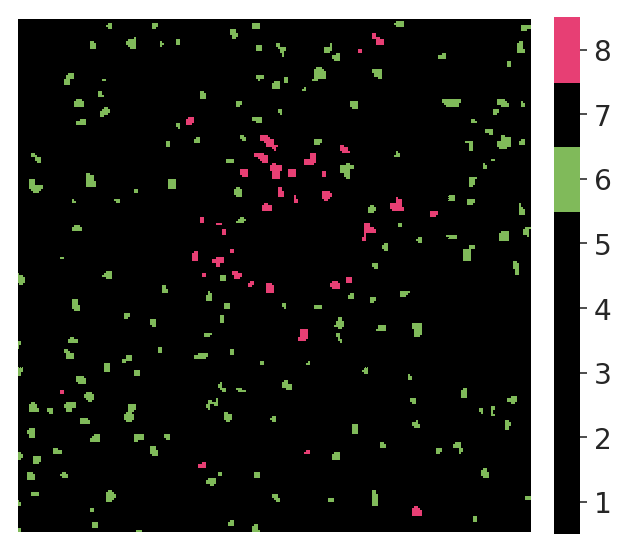

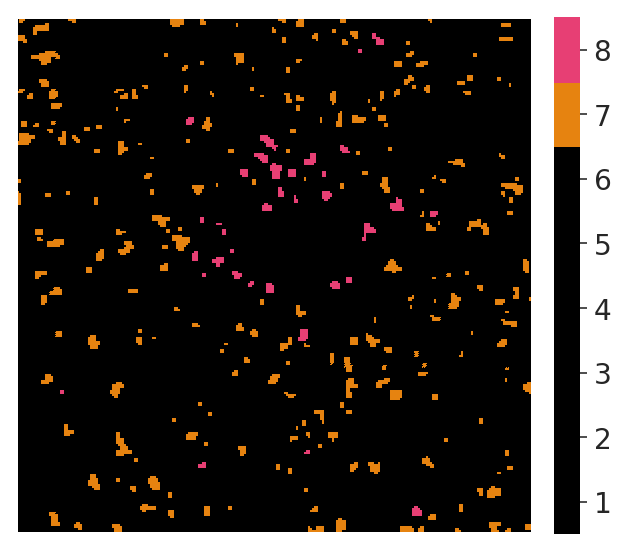

In [528]:
for i in range(8):
    for j in range(i+1,8):
        cur_save = save_cluster_image.format(str(i)+'-'+str(j))
        plot_label_image(a.obs['cls_8_reorder'],a.uns['cls_8_reorder_colors'],mask=[i,j],save=cur_save)
        
        

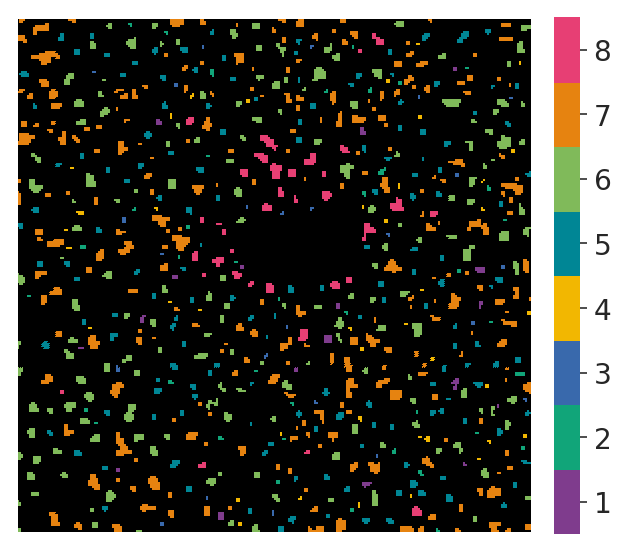

In [529]:
# 所有四色
# tmp_cmp = ['w']*3
# tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig2/c8/cluster_image/cluster_image_all.pdf'
plot_label_image(a.obs['cls_8_reorder'],a.uns['cls_8_reorder_colors'],mask=None,save=cur_save)


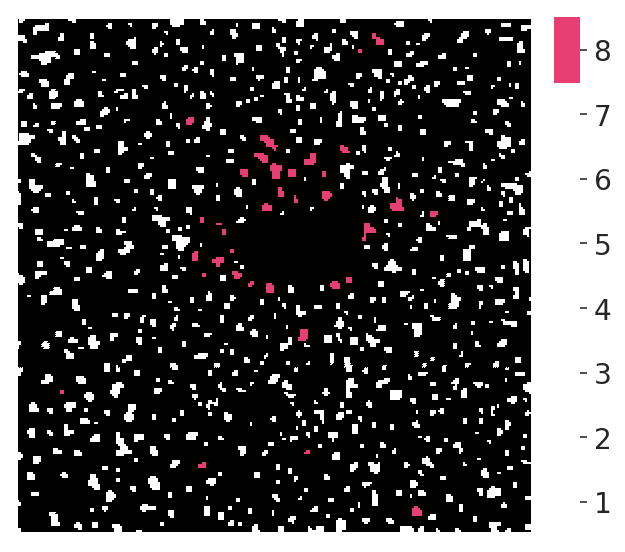

In [530]:
# 4红其他白
tmp_cmp = ['w']*7
tmp_cmp.append(a.uns['cls_8_reorder_colors'][7])
cur_save = '/home/yzy/ipynbs/figures/Fig2/c8/cluster_image/cluster_image_nearfar.pdf'
plot_label_image(a.obs['cls_8_reorder'],tmp_cmp,mask=None,save=cur_save)


In [359]:
np.unique(a.obs['pred'])

array(['1', '2', '3', '4', '5'], dtype=object)

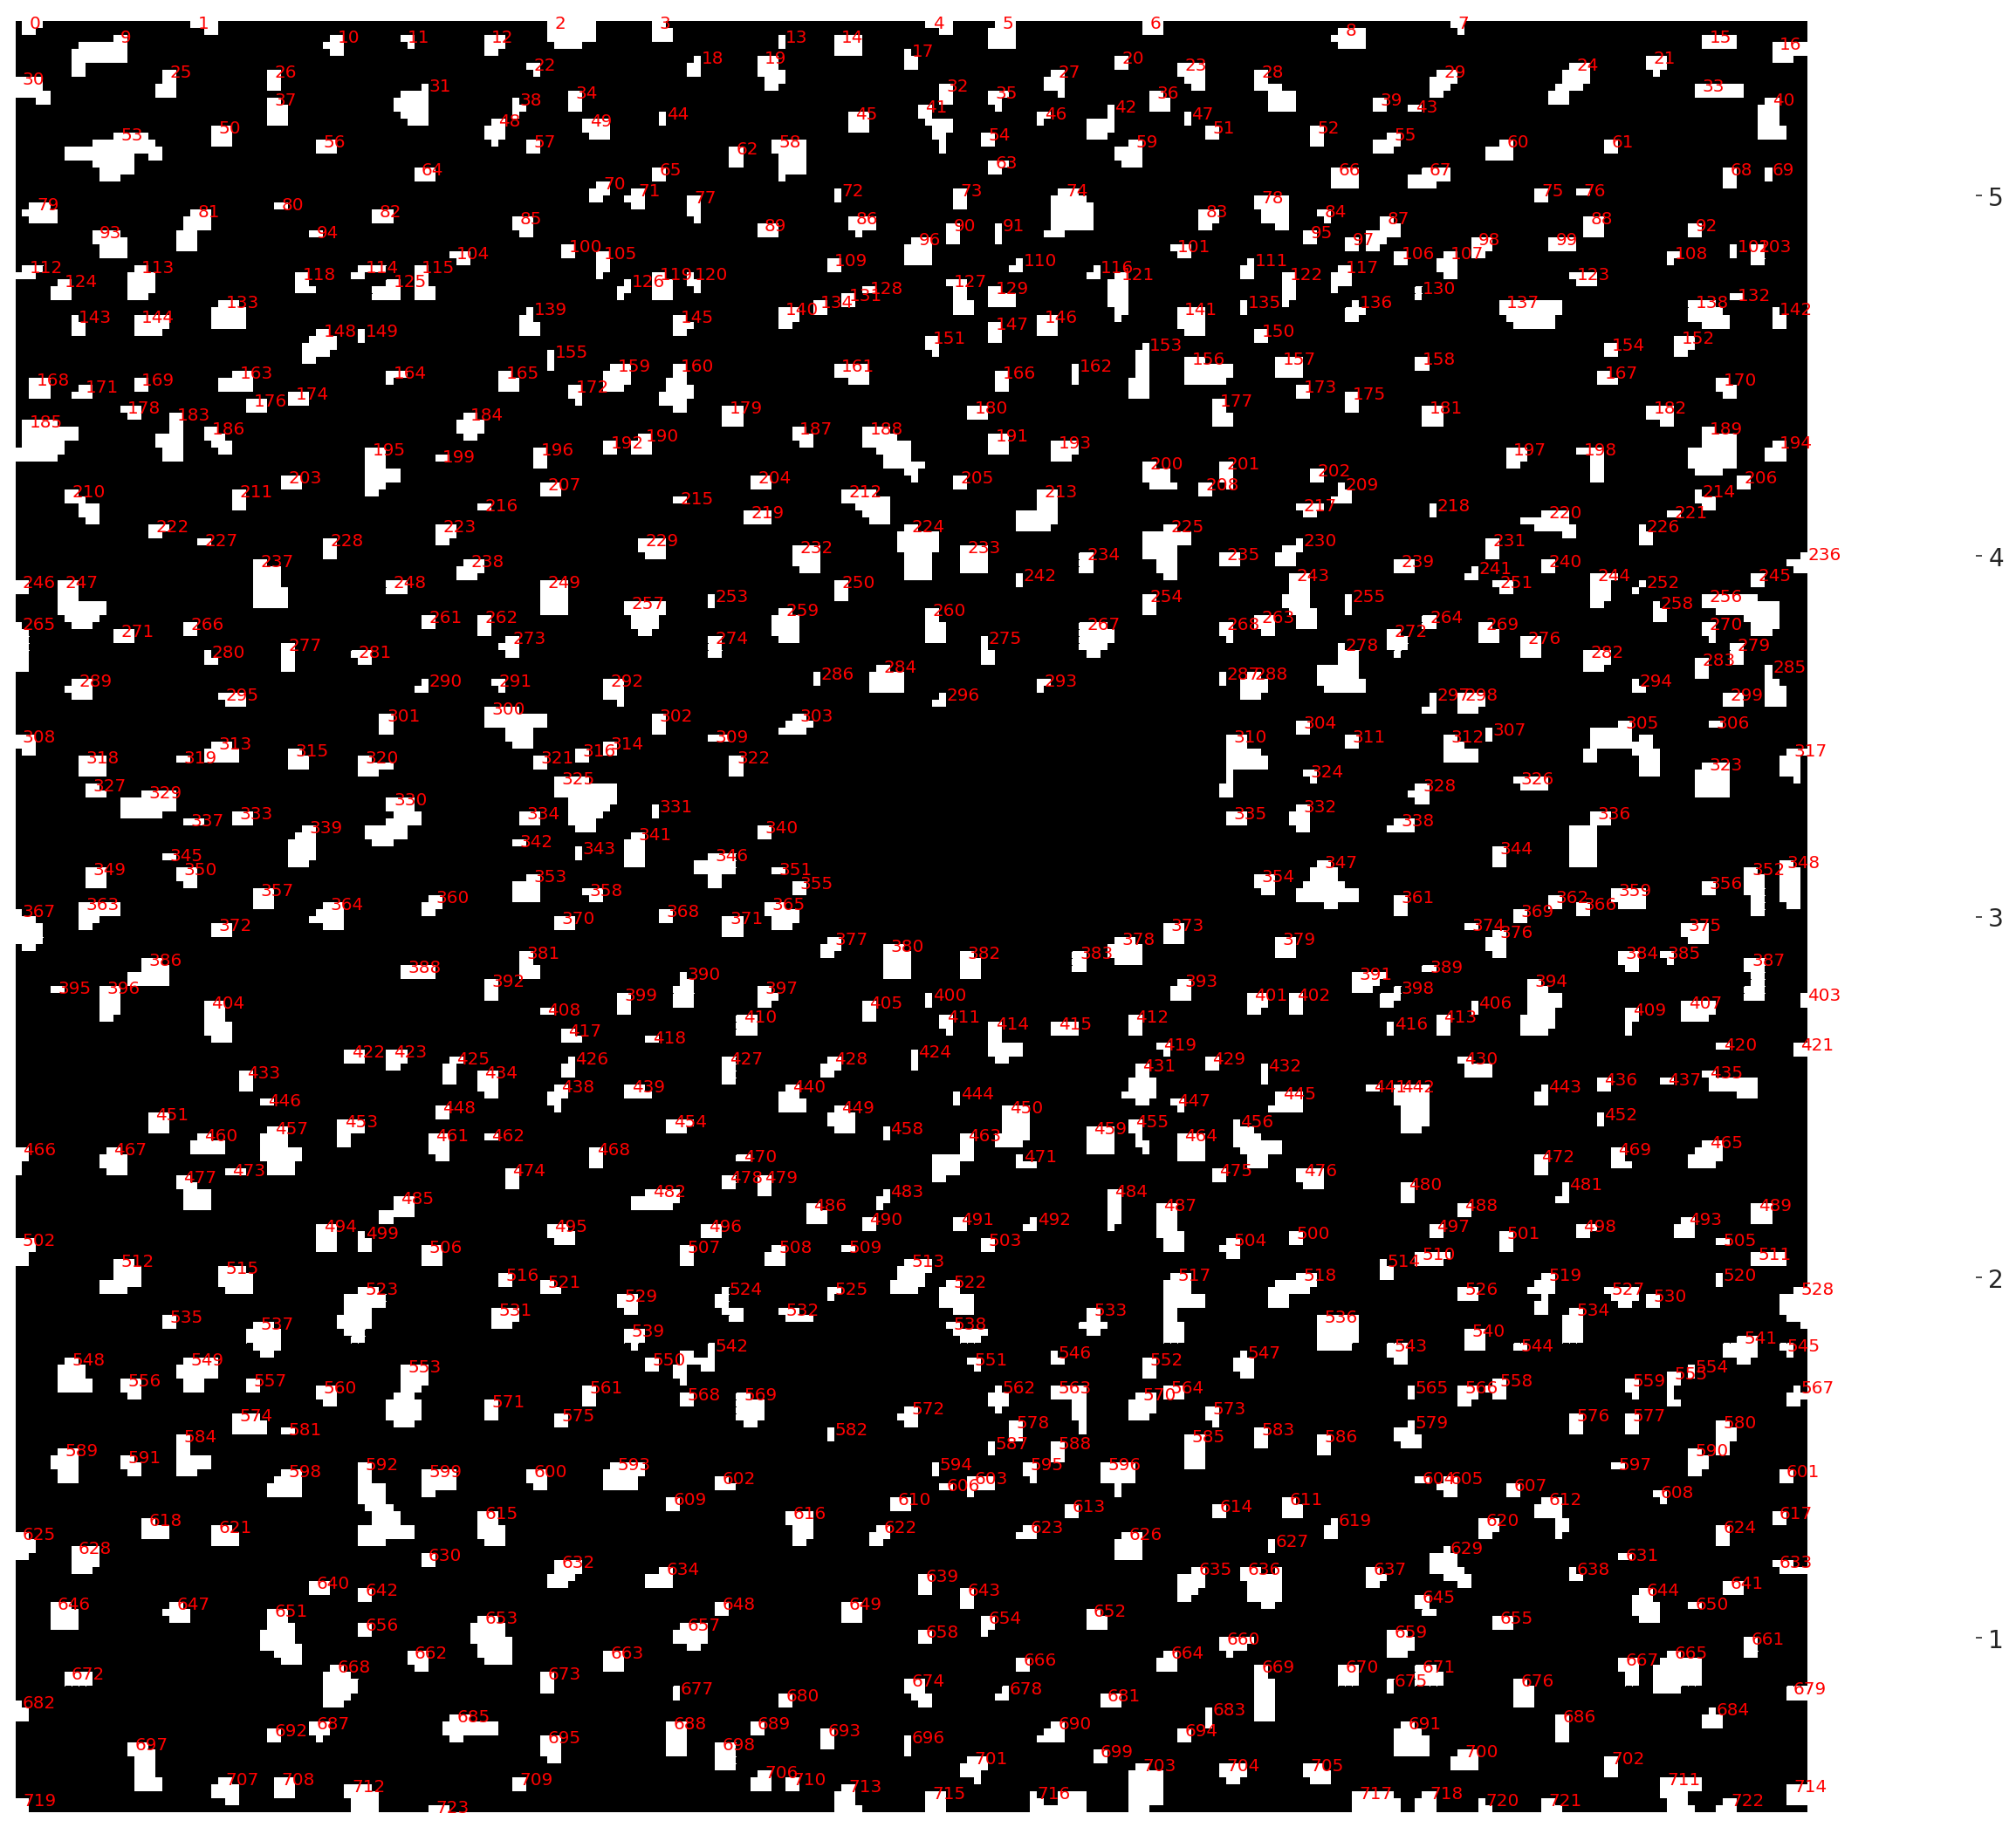

In [363]:
# 全白
tmp_cmp = ['w']*5
# tmp_cmp.append(a.uns['cls_4_colors'][3])
cur_save = '/home/yzy/ipynbs/figures/Fig2/c4/cluster_image/cluster_image_cut.pdf'
# plot_label_image(a.obs['cls_4'],tmp_cmp,mask=[0,1,2,3],save=cur_save)
plot_label_image(a.obs['pred'],tmp_cmp,mask=None,save=None,figsize=(20,20))


## differential expression heatmap

In [75]:
sc.tl.rank_genes_groups(a,groupby='cls_4',method='t-test',reference='3')

ranking genes
    finished (0:00:00)


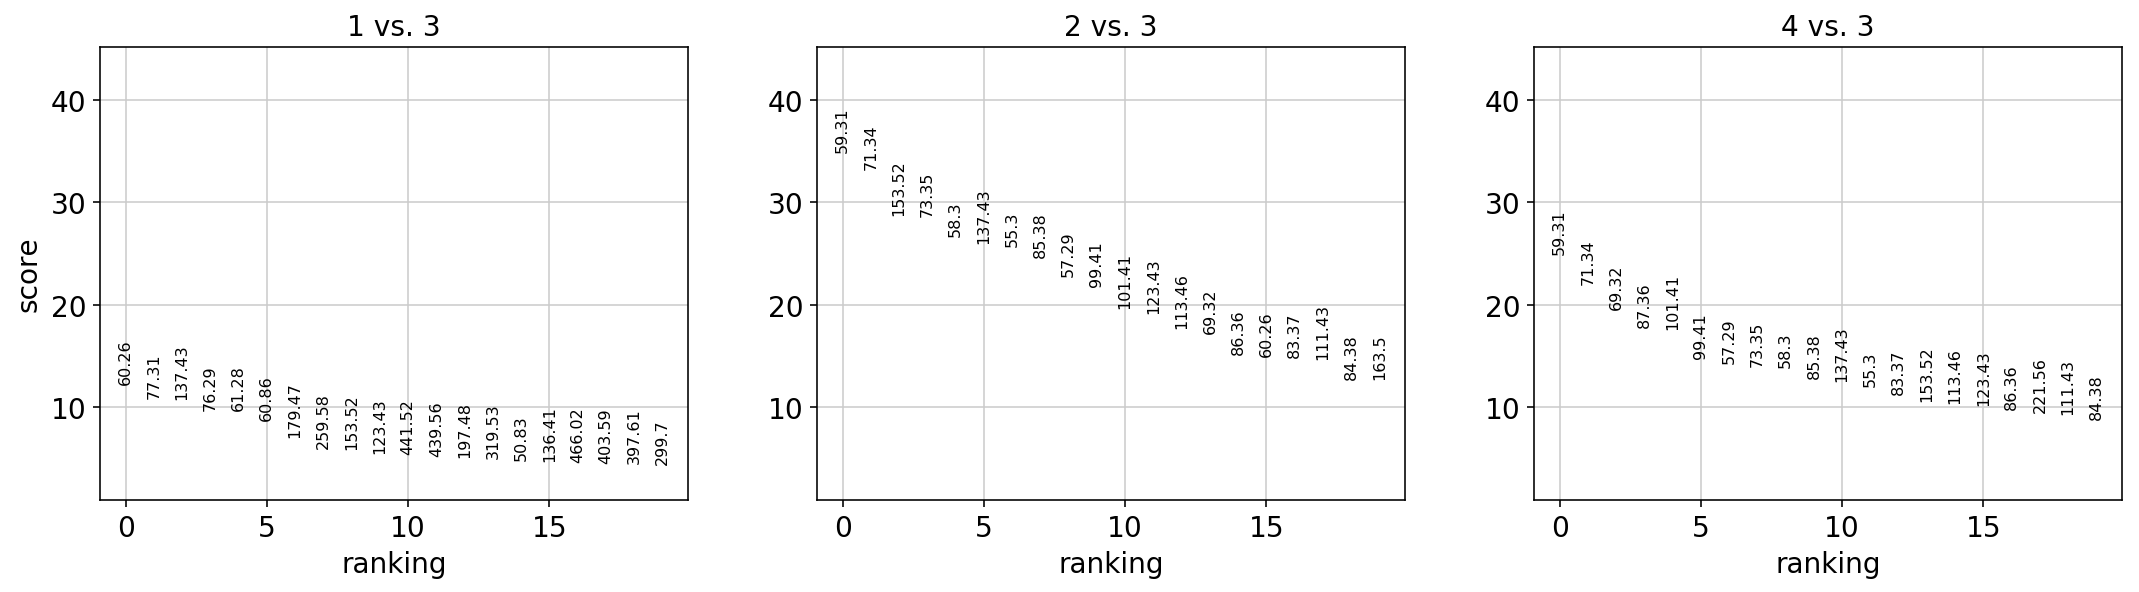

In [76]:
sc.pl.rank_genes_groups(a)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_cls_4']`


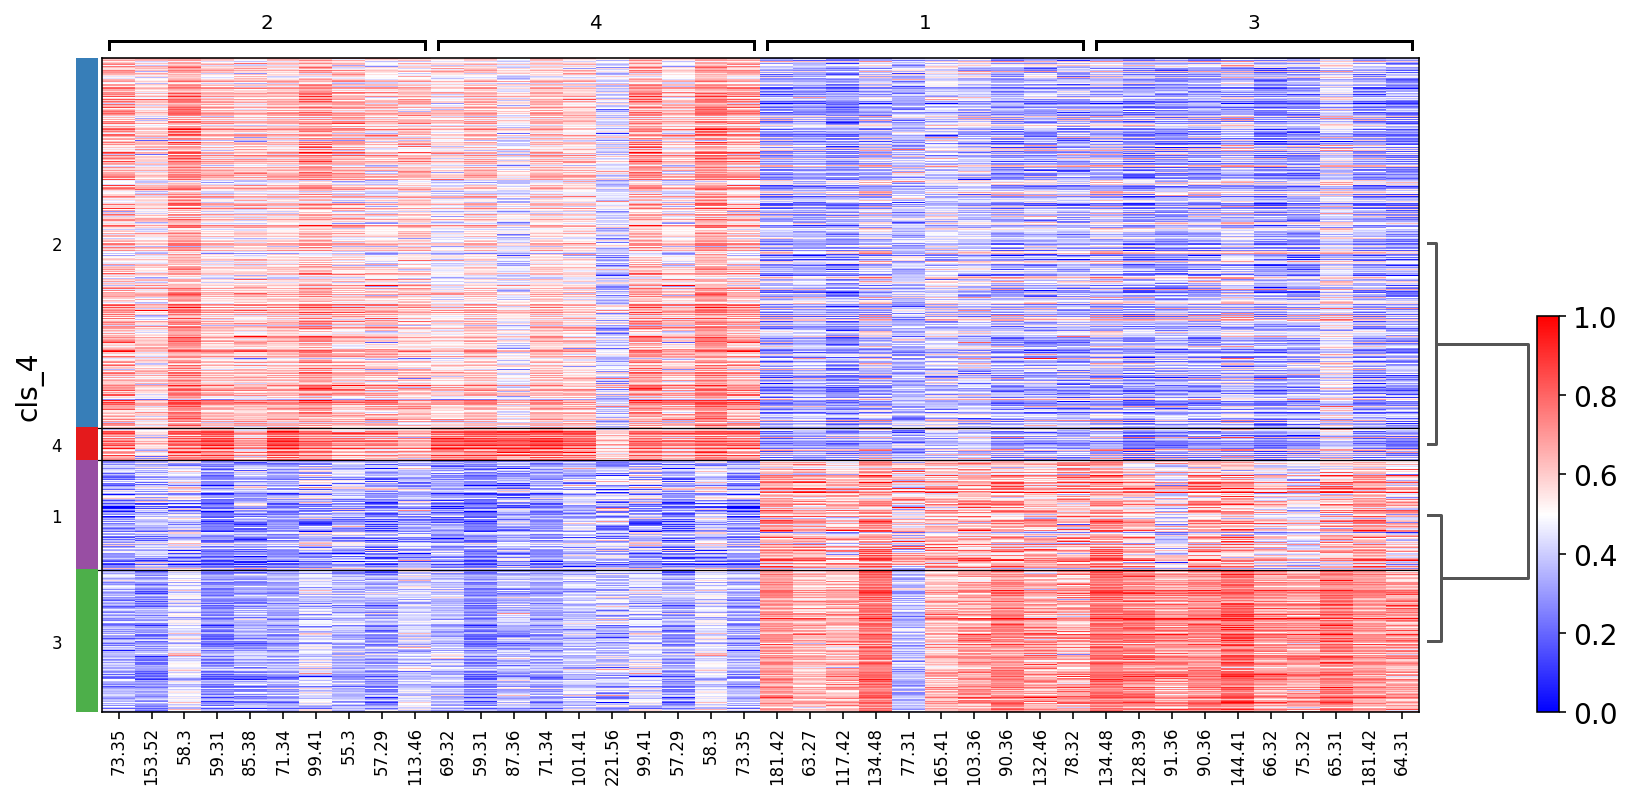

In [72]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=True,save=None)


In [157]:
a_cls13 = a[a.obs['cls_4'].isin(['1','3'])]

/home/yzy/anaconda3/envs/pytorch/lib/python3.7/site-packages/anndata/_core/anndata.py:1118: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


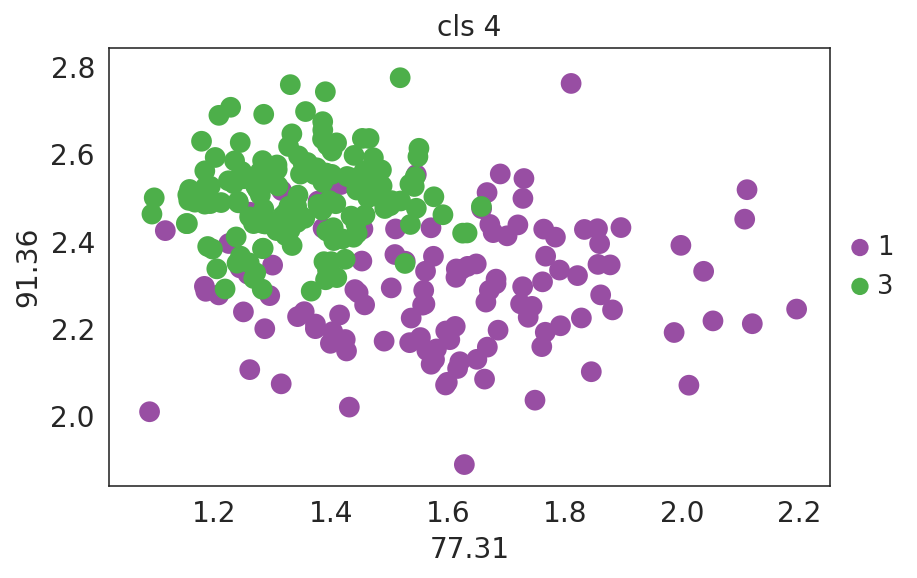

In [161]:
sc.pl.scatter(a_cls13,x='77.31',y='91.36',color='cls_4')

In [154]:
# 3 vs 1:91.36,75.32,66.32,65.31
# 1 vs 3:60.26,77.31,137.43,76.29

marker_list =[
    #     IC
    181.42,144.41,128.39,91.36,
    #     EC:
    60.26,77.31,137.43,

#     Hepa
    253.79,255.83,281.87,
    #     Hepa87+
#     221.56,87.36,101.41,59.31,71.34,
    58.30,69.32,59.31,71.34,101.41,87.36


]
marker_list = np.array(marker_list).astype('str')

Index(['50.27', '50.83', '51.29', '52.29', '53.29', '54.32', '55.3', '56.31',
       '57.29', '58.3',
       ...
       '409.57', '419.54', '425.58', '439.56', '441.52', '443.57', '447.59',
       '457.52', '466.02', '487.6'],
      dtype='object', name='index', length=244)

In [103]:
a_tmp = a.copy()

In [149]:
# a_tmp.obs.cls_4.cat.reorder_categories(['3','1','2','4'], inplace=True) 
a_tmp.uns['cls_4_colors'] = [cur_cmp[2],cur_cmp[0],cur_cmp[1],cur_cmp[3]]

In [105]:
a_tmp.obs.cls_4.cat.categories
['3','1','2','4']

Index(['1', '2', '3', '4'], dtype='object')

In [457]:
a_tmp.var_names

Index(['50.27', '50.83', '51.29', '52.29', '53.29', '54.32', '55.3', '56.31',
       '57.29', '58.3',
       ...
       '409.57', '419.54', '425.58', '439.56', '441.52', '443.57', '447.59',
       '457.52', '466.02', '487.6'],
      dtype='object', name='index', length=244)

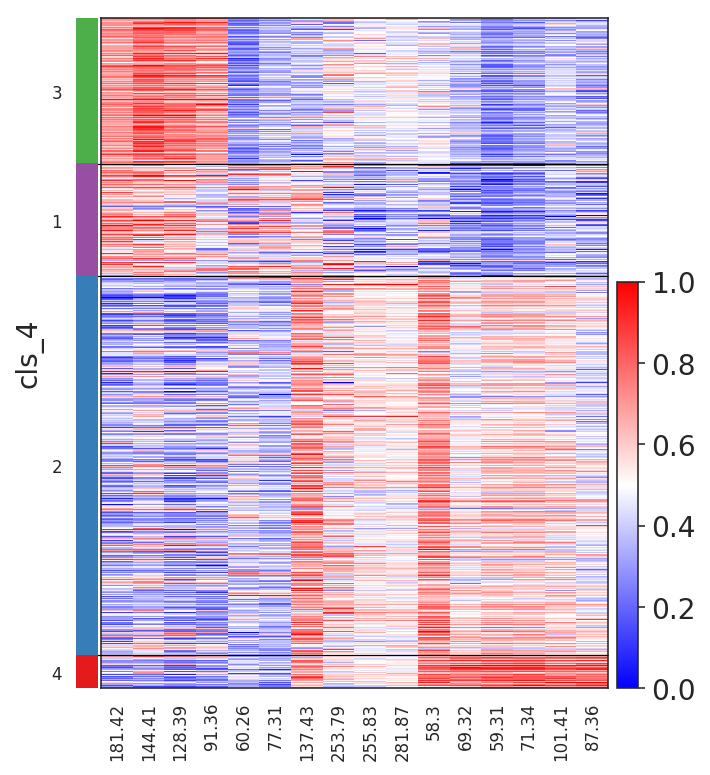

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 4.8, 0, 0.2])

In [458]:
sc.settings.figdir = 'figures/Fig2/c4/diff/'
save_heatmap = '_c4.pdf'
# sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=save_heatmap)
# sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=None)
sc.pl.heatmap(a_tmp, marker_list,groupby='cls_4',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


## marker expression on umap

In [124]:
a

AnnData object with n_obs × n_vars = 724 × 244 
    obs: 'pred', 'cls_4', 'cell_CV_dist'
    uns: 'dendrogram_pred', 'pred_colors', 'rank_genes_groups', 'rep_list', 'CV_pos', 'cls_4_colors', 'dendrogram_cls_4', 'neighbors'
    obsm: 'X_umap', 'X_pca', 'pos'

In [129]:
sc.pp.neighbors(a,use_rep='pos',n_neighbors=5)

computing neighbors
    finished (0:00:00)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

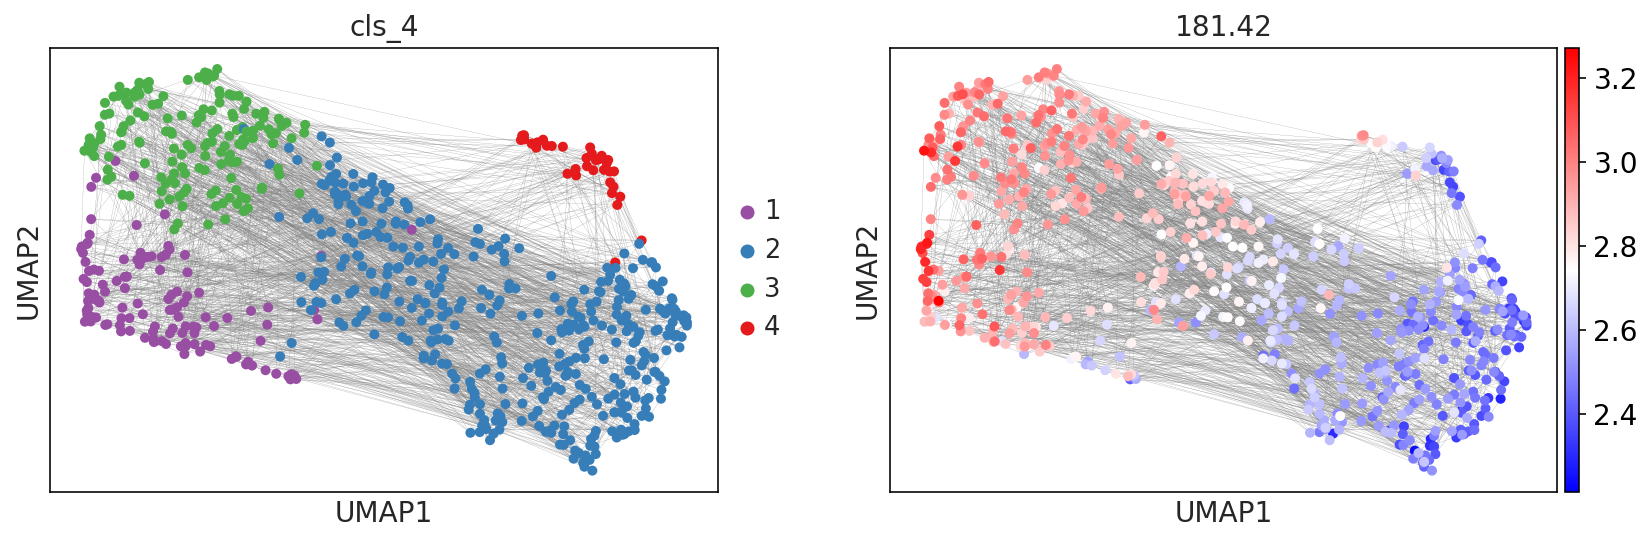

In [130]:
sc.pl.umap(a,color=['cls_4',marker_list[0]],color_map='bwr',s=100,edges=True)

In [1]:
sc.settings.figdir = 'figures/Fig2/c8/diff/'
sc.set_figure_params(transparent=True)
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap
save_heatmap = '_{m}_trans_c8.pdf'
for m in marker_list:
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    cur_save = save_heatmap.format(m=m)
    sc.pl.umap(a,color=[m],color_map=heatmap_cmp,s=100,frameon=False,ax=ax,save=cur_save,)
#     sc.pl.umap(a,color=[m],color_map=heatmap_cmp,s=100,frameon=False,ax=ax,save=None,)

    


NameError: name 'sc' is not defined

## cell-CV distance & t-test

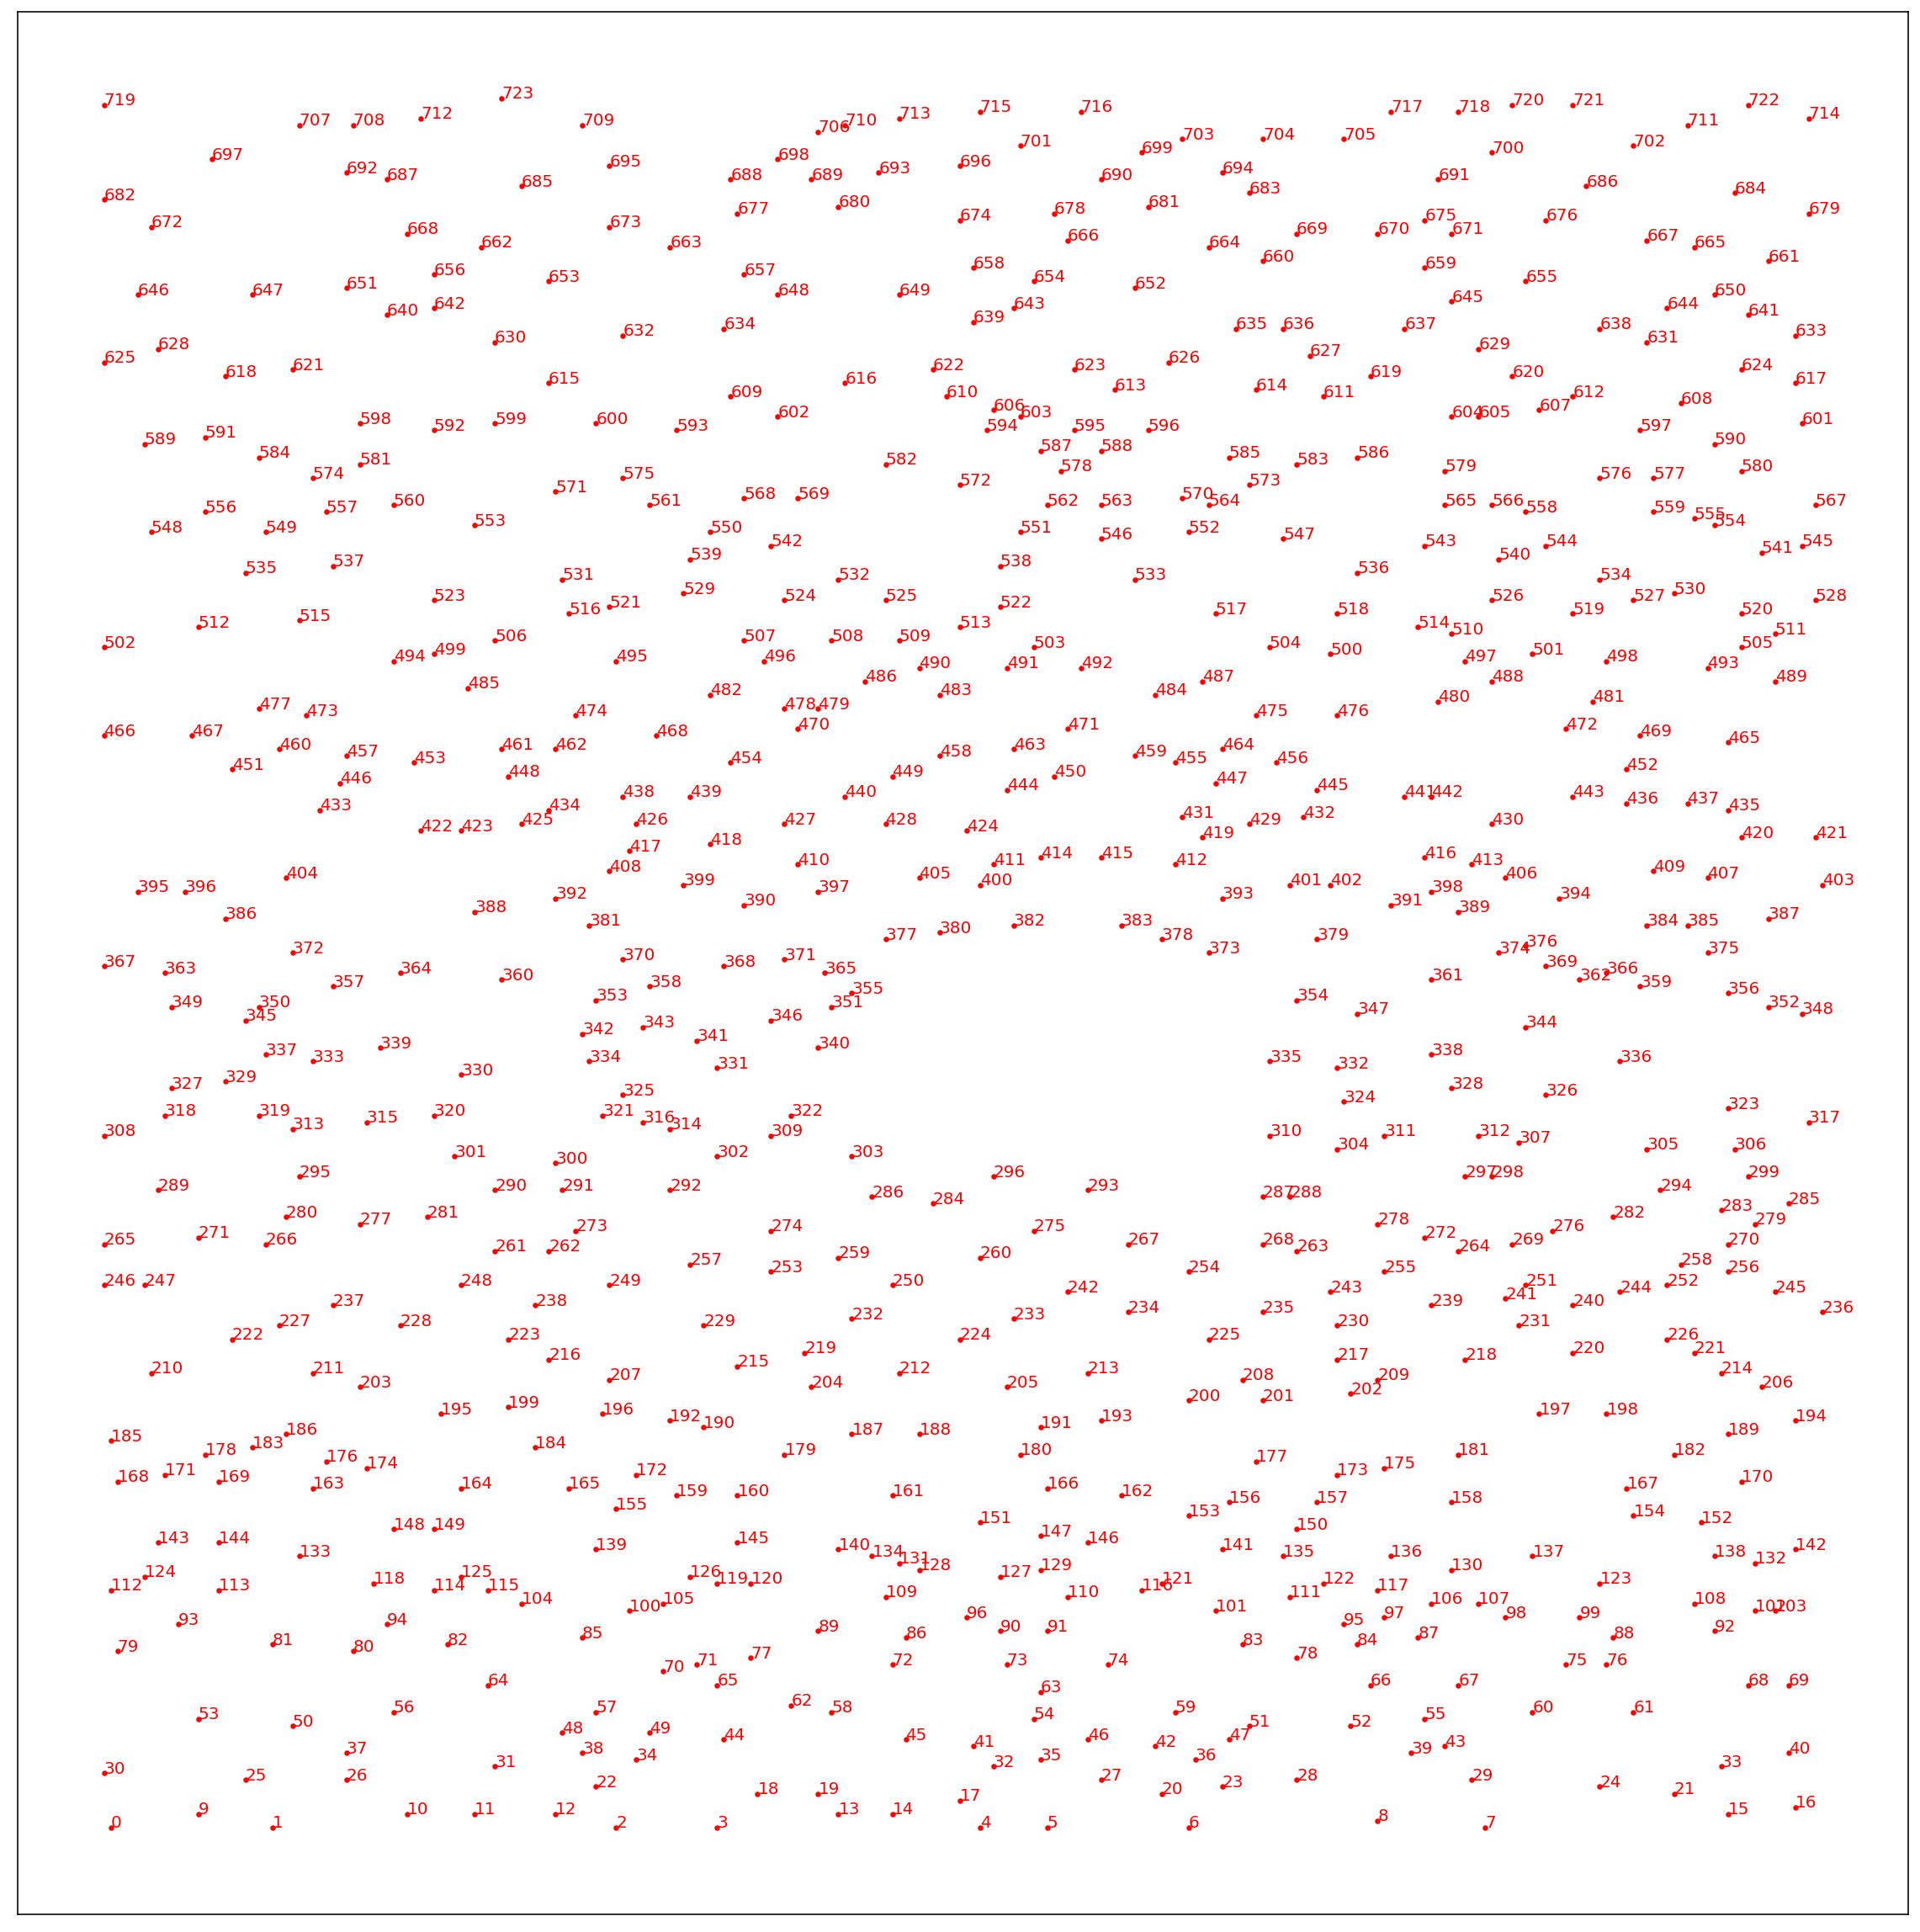

In [8]:
# to_show_x = train_x[:,np.where(matter_list==115.35)]
# to_show_x = train_x[:,matter_list==255.21][:,0]
# to_show_x = train_x[:,matter_list==87.36][:,0]
# to_show_x = train_x_HEG[:,9]
# train_x_preprocess = (train_x)/np.sum(train_x,axis=1,keepdims=True)
cell_pos_list = []
# to_show_x = train_x[:,matter_list==181.42][:,0]

# to_show_x = train_x_preprocess[:,0]
# to_show_x = order_mat[391,:]

plt.figure(figsize=(20,20))
# to_show_img = np.zeros(shape=65536,)
# to_show_img[cell_pos-1] = to_show_x
# to_show_img=to_show_img.reshape(256,256)
# plt.imshow(to_show_img,cmap='jet')
# sns.heatmap(to_show_img,cmap='jet',cbar=False)
for i in range(a.shape[0]):
    cur_idx = i + 1
    cur_ind = cell_pos[cell_idx==cur_idx][0]
    cur_ind_list = cell_pos[cell_idx==cur_idx]
    cur_x_list = []
    cur_y_list = []
    for j in cur_ind_list:
        cur_x = ind2ij(cur_ind,256,1)
        cur_y = ind2ij(cur_ind,256,0)
        cur_x_list.append(cur_x)
        cur_y_list.append(cur_y)
    cur_x_mean = np.mean(cur_x_list)
    cur_y_mean = np.mean(cur_y_list)
#     print(ind2ij(cur_ind,256,0))
#     print(ind2ij(cur_ind,256,1))
    cell_pos_list.append(np.array([cur_x_mean,cur_y_mean]))
    plt.annotate(str(cur_idx-1),(ind2ij(cur_ind,256,1),ind2ij(cur_ind,256,0)),color='red')
    plt.scatter(cur_x_mean, cur_y_mean, s=5, c='red', marker='o')
# plt.colorbar()
# plt.scatter(CV_pos[0],CV_pos[1],s=10,c='blue',marker='o')
plt.xticks([])
plt.yticks([])
plt.show()
cell_pos_mat = np.array(cell_pos_list)
# 286,284,296,275,293,267,288,310,335,373,378,383,382,380,377,365,355,351,340,322,303

In [11]:
a.obsm['spatial'] = cell_pos_mat

In [16]:
CV_pos = (cell_pos_mat[293]+cell_pos_mat[382])/2

In [536]:
cell_CV_dist = np.sqrt(np.sum(np.power(cell_pos_mat-CV_pos,2),axis=1))

In [537]:
a.obsm['pos'] = cell_pos_mat
a.uns['CV_pos'] = CV_pos
a.obs['cell_CV_dist'] = cell_CV_dist

In [19]:
sns.set_style('white')

In [20]:
a.obs['cell_CV_dist']*(400/256)

index
0      281.000323
1      253.021294
2      203.979573
3      193.475738
4      178.101013
5      177.345471
6      180.213225
7      203.979573
8      191.420599
9      263.477069
10     229.387027
11     219.543761
12     208.665425
13     181.037726
14     178.046172
15     234.544210
16     244.172810
17     172.389146
18     182.648832
19     177.895274
20     171.480371
21     222.778201
22     198.335973
23     172.629735
24     210.784088
25     250.109839
26     233.134739
27     166.818372
28     175.907940
29     192.945026
          ...    
694    207.762564
695    229.546619
696    206.548671
697    284.085103
698    216.486616
699    209.657575
700    232.348006
701    210.273840
702    249.865687
703    213.899915
704    217.364474
705    222.361373
706    219.988126
707    276.604428
708    268.906659
709    240.728975
710    220.065797
711    260.691782
712    261.103521
713    219.243305
714    278.802283
715    218.585317
716    218.082128
717    231.811502
718 

In [538]:
a_hepa = a[a.obs['cls_8_reorder'].isin(['5','6','7','8'])]

In [534]:
a_hepa

View of AnnData object with n_obs × n_vars = 603 × 244 
    obs: 'pred', 'cls_sub', 'louvain', 'cls_6', 'cls_7', 'cls_8', 'annotation', 'cls_5', 'cls_8_reorder', 'celltype_cls8'
    uns: 'dendrogram_pred', 'pred_colors', 'rank_genes_groups', 'rep_list', 'cls_sub_colors', 'neighbors', 'louvain', 'cls_6_colors', 'cls_7_colors', 'cls_8_colors', 'annotation_colors', 'dendrogram_cls_8', 'celltype_cls8_colors', 'cls_8_reorder_colors'
    obsm: 'X_umap', 'X_pca'

In [545]:
pd_dict = {
    'cell_idx' :a_hepa.obs_names,
    'cell_type':a_hepa.obs['cls_8_reorder'],
    'cell_CV_dist':a_hepa.obs['cell_CV_dist']*(400/256)
}
pd_df = pd.DataFrame(pd_dict)

In [26]:
a

AnnData object with n_obs × n_vars = 724 × 244 
    obs: 'pred', 'cls_4', 'cell_CV_dist'
    uns: 'dendrogram_pred', 'pred_colors', 'rank_genes_groups', 'rep_list', 'CV_pos'
    obsm: 'X_umap', 'X_pca', 'pos'

30.39855696616206

In [34]:
a.uns['cls_4_colors']

[(0.596078431372549, 0.3058823529411765, 0.6392156862745098),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745)]

In [45]:
pd_df.cell_type[0]

'2'

In [ ]:
pd_df_tmp = pd_df.copy()


In [69]:
pd_df = pd_df_tmp.copy()


NameError: name 'pd_df_tmp' is not defined

In [546]:
# pd_df.iloc[:,2] = np.random.rand(pd_df.iloc[:,2].shape[0])
pd_df.iloc[:,0] = pd_df.iloc[:,0].astype('int')
pd_df.iloc[:,1] = pd_df.iloc[:,1].astype('int')

In [541]:
sns.set_style('white')

In [552]:
a_hepa.uns['cls_8_reorder_colors']

array([[0.        , 0.5254902 , 0.58431373],
       [0.50196078, 0.72941176, 0.35294118],
       [0.90196078, 0.51372549, 0.0627451 ],
       [0.90588235, 0.24705882, 0.45490196]])

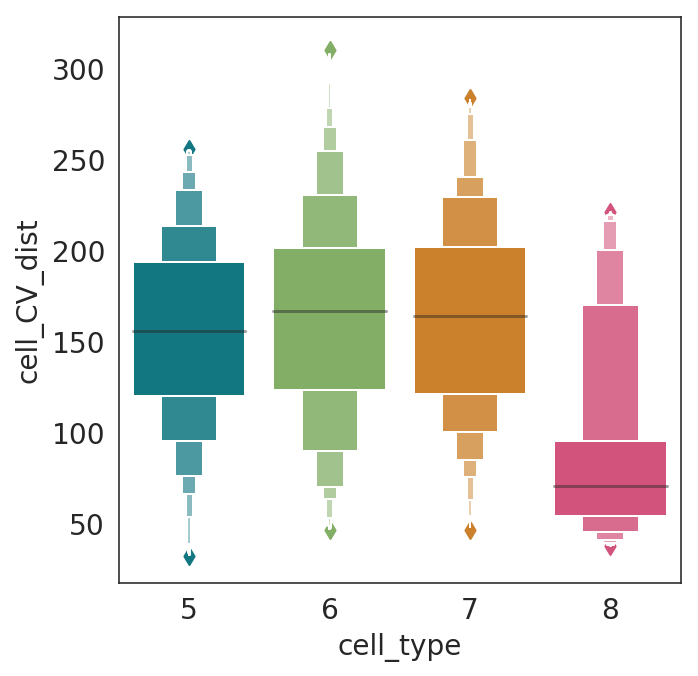

In [553]:
CV_dist_save = '/home/yzy/ipynbs/figures/Fig2/c8/CV_dist_boxen_hepa_c8.pdf'
fig,axes = plt.subplots(1,1,figsize=(5,5))
# sns.swarmplot(y="cell_type", x="cell_CV_dist",ax=axes,data=pd_df)
sns.boxenplot(x="cell_type", y="cell_CV_dist",ax=axes,data=pd_df,palette=a_hepa.uns['cls_8_reorder_colors'])

# sns.violinplot(x="cell_type", y="cell_CV_dist",ax=axes,data=pd_df)

plt.savefig(CV_dist_save,transparent=True,format='pdf',bbox_inches='tight')


In [83]:
pd_df[pd_df.cell_type==4].cell_CV_dist

index
2      203.979573
28     175.907940
51     160.660411
159    132.954887
188     91.915648
200     85.159834
212     80.714884
213     73.162717
224     68.188402
232     75.785277
233     60.766989
234     61.287058
260     48.926463
267     46.574558
275     40.034775
278     84.901425
284     43.315363
298    105.933582
302     80.593805
309     67.287353
310     53.866607
322     61.604919
340     53.957177
341     82.124203
346     65.410737
365     55.868935
368     78.662215
373     43.986526
377     47.043966
378     37.581292
380     38.732985
450     64.848456
535    217.588995
623    158.688011
634    184.272350
691    221.393073
Name: cell_CV_dist, dtype: float64

In [85]:
import scipy

In [162]:
# 87+距离CV vs 87+&87- 距离CV的ranksum test
tmp=scipy.stats.ranksums(pd_df[pd_df.cell_type==4].cell_CV_dist,pd_df[pd_df.cell_type.isin([2,4])].cell_CV_dist)

In [164]:
tmp[1]

8.602308079622366e-10

In [90]:
pd_df[pd_df.cell_type.isin([2,4])]

(445, 3)

In [ ]:
for i in range(4):
    

In [165]:
1+1

2

## CD45 test

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

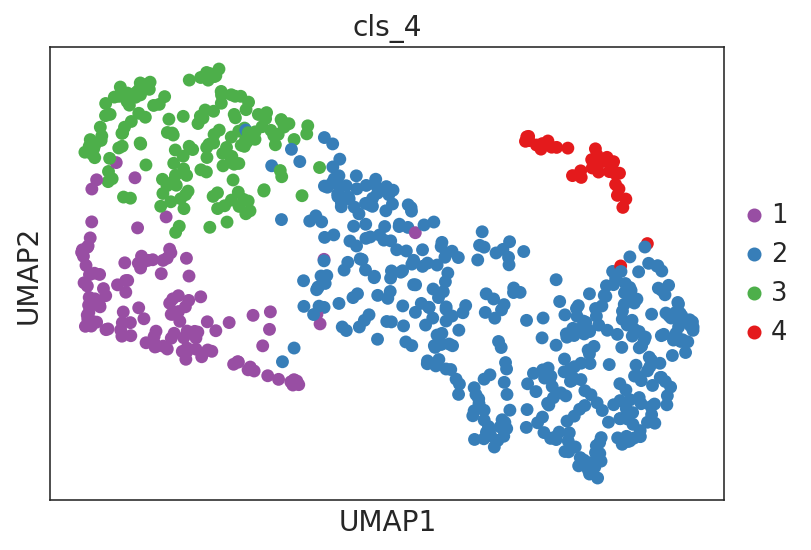

In [167]:
sc.pl.umap(a,color='cls_4')

In [168]:
a_ec = a[a.obs['cls_4']=='1']

In [172]:
sc.pp.neighbors(a_ec)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)


In [173]:
sc.tl.umap(a_ec)
sc.tl.louvain(a_ec)

computing UMAP
    finished (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


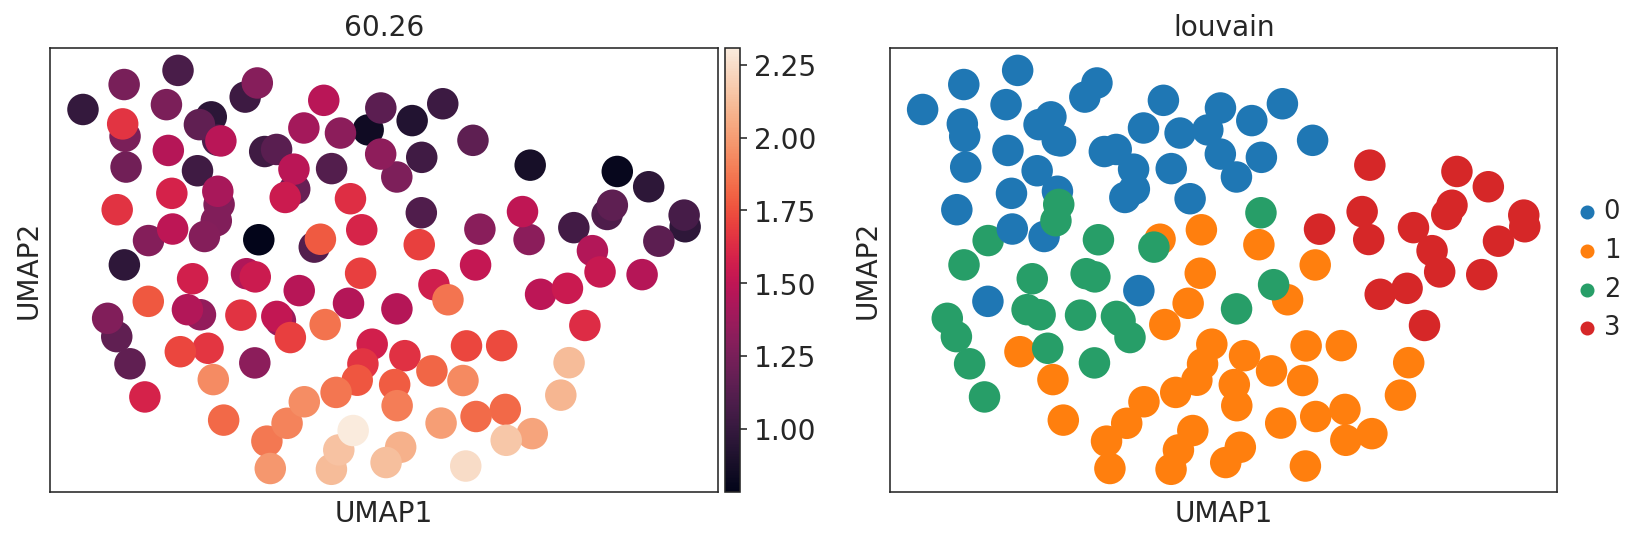

In [174]:
sc.pl.umap(a_ec,color=['60.26','louvain'])

In [176]:
sc.tl.rank_genes_groups(a_ec,groupby='louvain')

ranking genes
    finished (0:00:00)


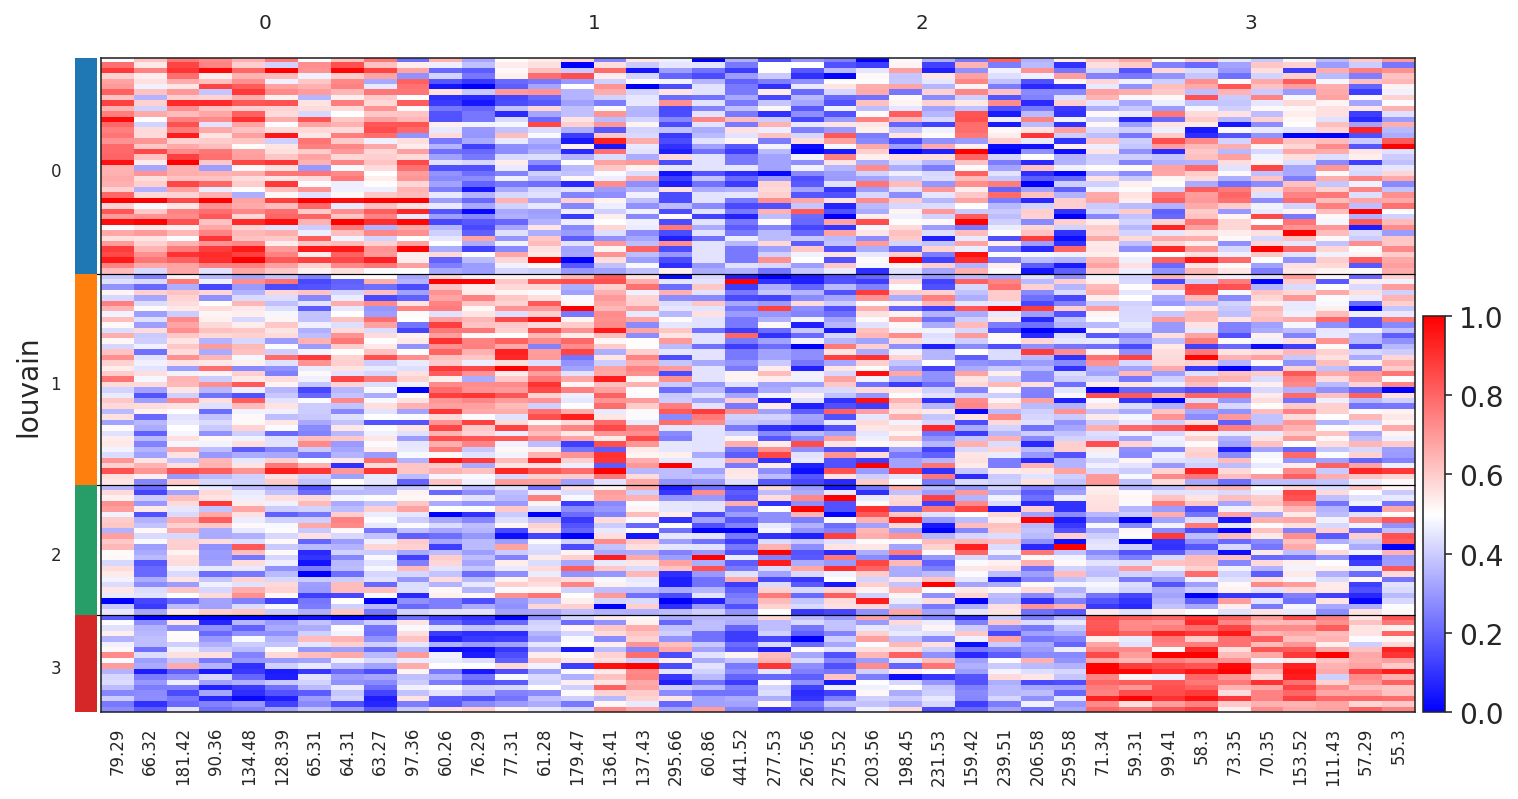

In [177]:
sc.pl.rank_genes_groups_heatmap(a_ec,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


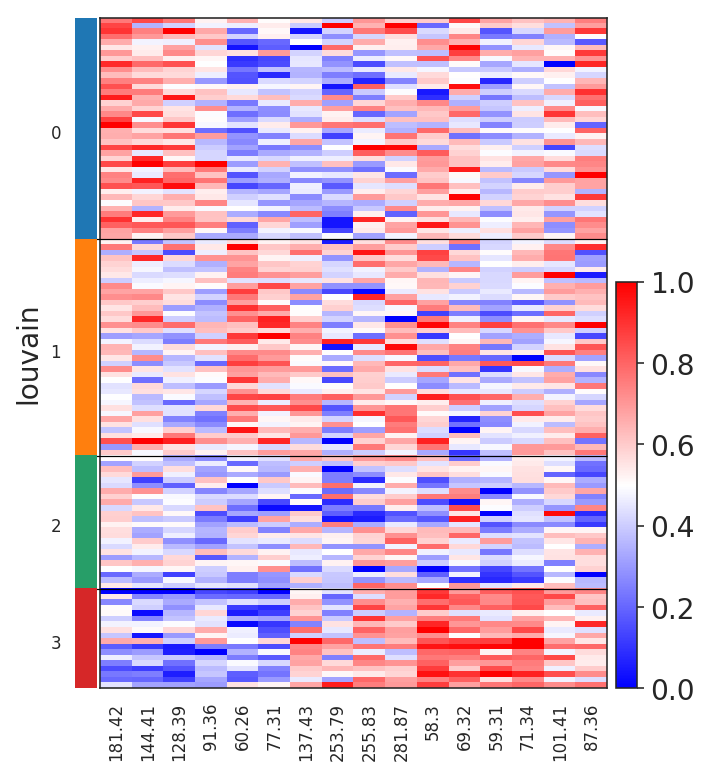

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 4.8, 0, 0.2])

In [175]:
sc.pl.heatmap(a_ec, marker_list,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [ ]:
a_cls_sub = np.ones()

In [10]:
def add_subcls(a_cls_sub,ec_cls,to_replace_cls):
    a_cls_sub_int = a_cls_sub.astype('int')
    a_cls_sub_int[a_cls_sub_int==int(to_replace_cls)] = -1
    a_cls_sub_int[a_cls_sub_int>int(to_replace_cls)]-=1
    a_cls_sub_int_max = a_cls_sub_int.max()
    
    ec_cls_int = ec_cls.astype('int')
    ec_cls_int -= ec_cls_int.min()
    ec_cls_int+=(a_cls_sub_int_max+1)
    a_cls_sub_int[a_cls_sub_int==-1] = ec_cls_int
    return a_cls_sub_int.astype('str')

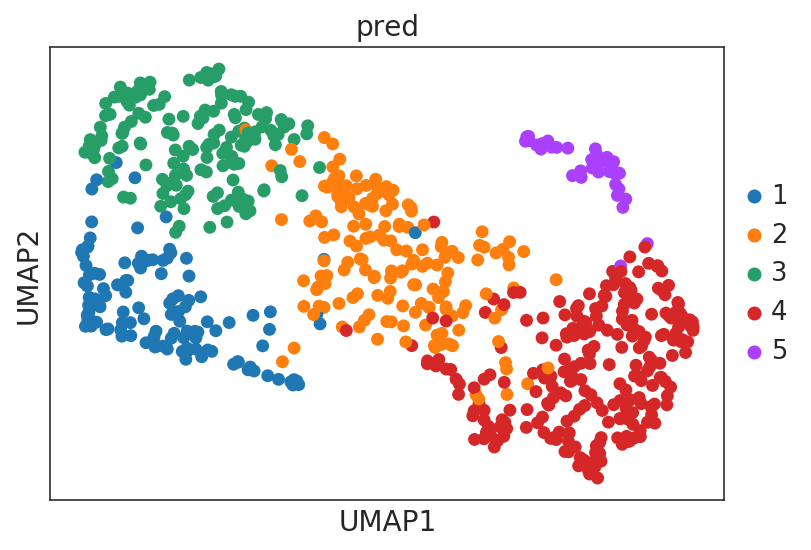

In [273]:
sc.pl.umap(a,color='pred')

In [274]:
a_cls_sub = np.array(a.obs['pred'])
ec_cls = np.array(a_ec.obs['louvain'])
to_replace_cls = '1'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

In [275]:
a.obs['cls_sub'] = a_cls_sub_modified
a.obs['cls_sub'] = a.obs['cls_sub'].astype('category')

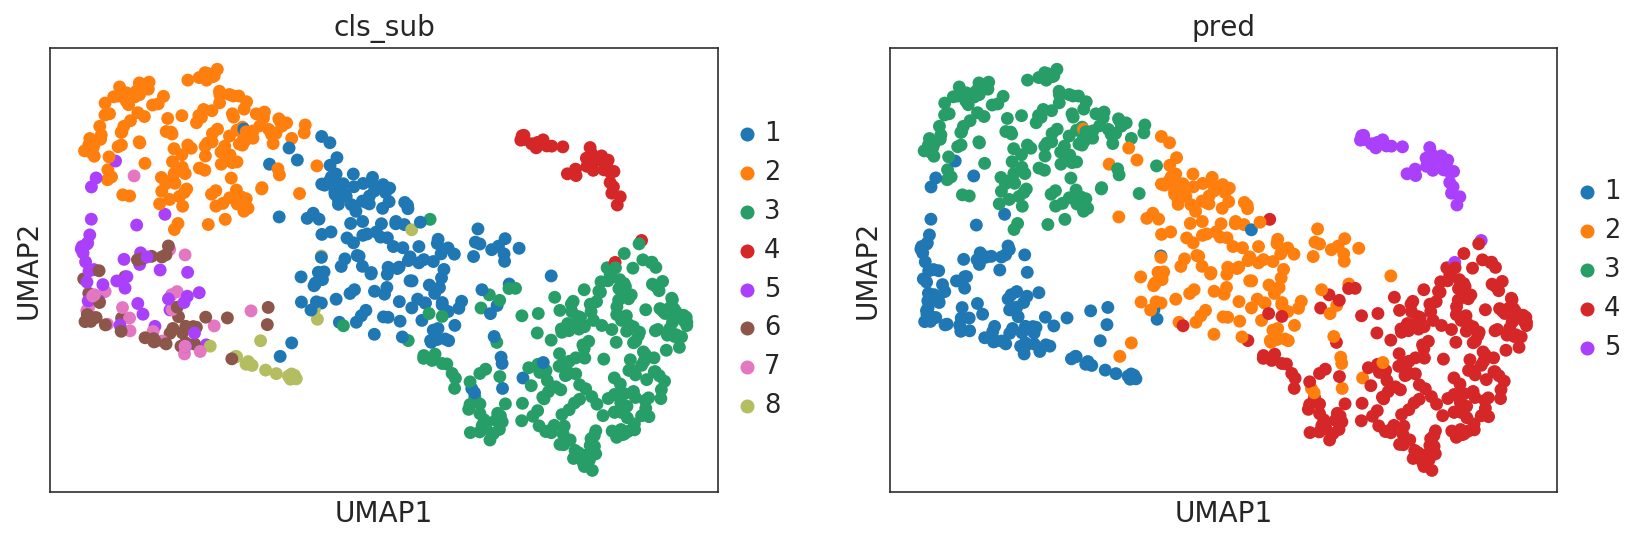

In [276]:
sc.pl.umap(a,color=['cls_sub','pred'])

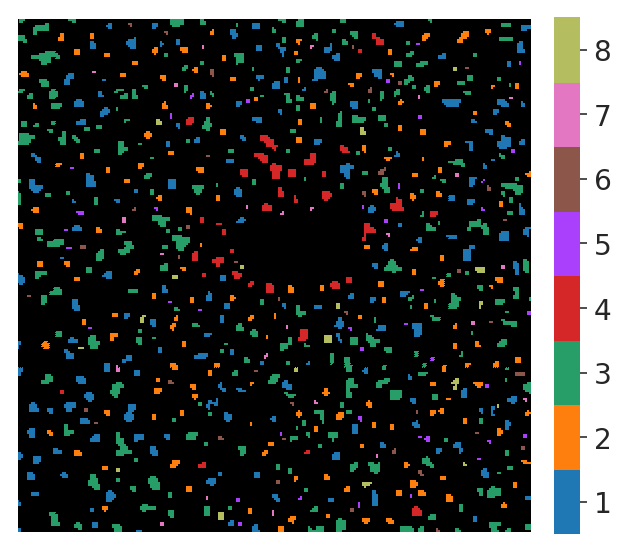

In [277]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=range(8),save=None)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

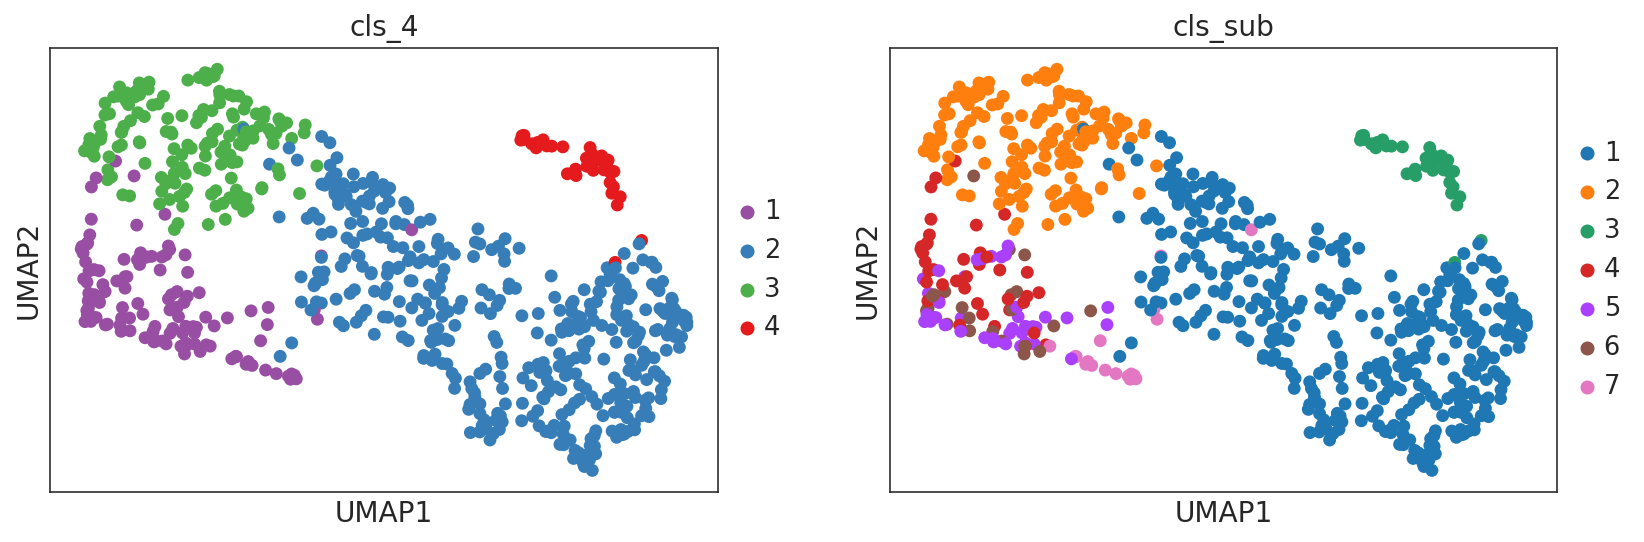

In [246]:
sc.pl.umap(a,color=['cls_4','cls_sub'])

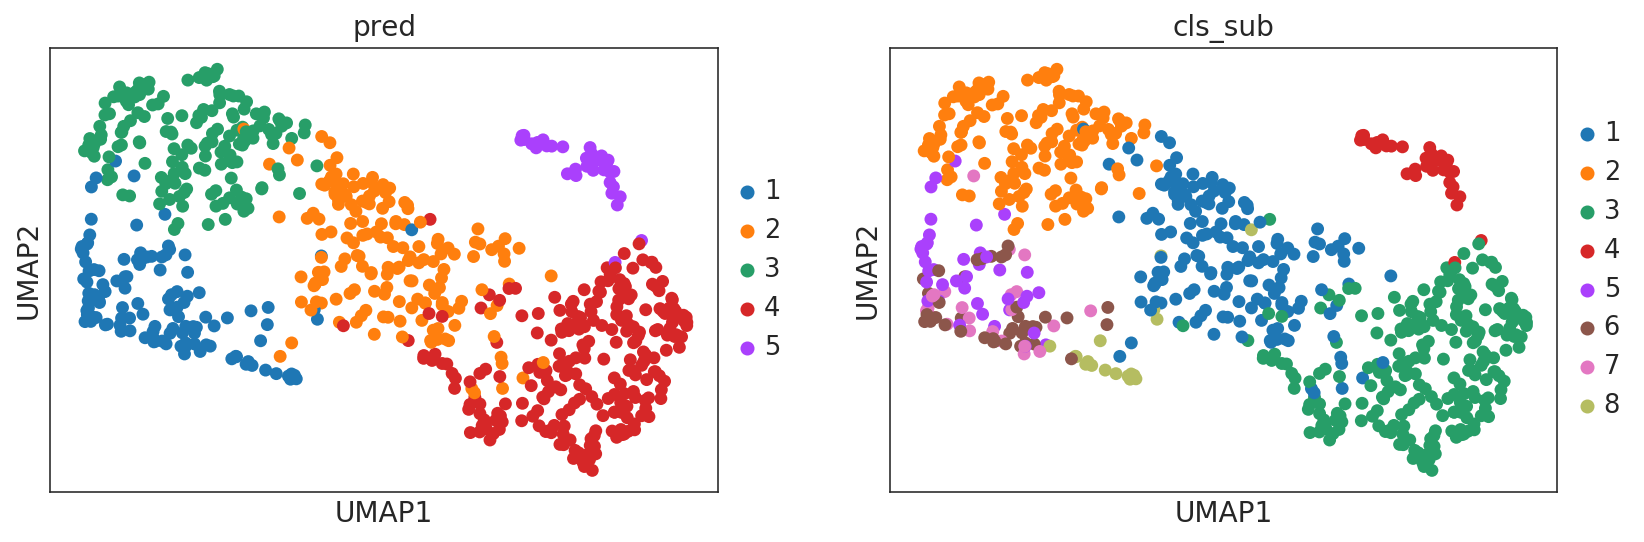

In [278]:
sc.pl.umap(a,color=['pred','cls_sub'])

In [247]:
a.obs['cls_sub_celltype'] = a.obs['cls_sub'].copy()

In [248]:
celltype_cmp = palettable.colorbrewer.qualitative.Dark2_8.mpl_colors

In [249]:
a.uns['cls_sub_celltype_colors'] = [celltype_cmp[0],celltype_cmp[0],celltype_cmp[0],celltype_cmp[7],celltype_cmp[1],celltype_cmp[1],celltype_cmp[5]]

In [254]:
cell_type_map = {
    '1':'Hepa',
    '2':'Hepa',
    '3':'Hepa',
    '4':'Hepa',
    '5':'Leu',
    '6':'Endo',
    '7':'Endo',
    '8':'Unknown'
}
cell_type_color = [celltype_cmp[0],celltype_cmp[7],celltype_cmp[1],celltype_cmp[5]]

In [259]:
a.obs['cell_type']

index
0         Hepa
1         Hepa
2         Hepa
3         Hepa
4         Hepa
5         Hepa
6         Hepa
7         Hepa
8         Hepa
9         Hepa
10        Hepa
11        Endo
12        Hepa
13        Hepa
14        Hepa
15        Hepa
16        Hepa
17        Hepa
18        Hepa
19        Hepa
20        Hepa
21        Hepa
22        Endo
23        Hepa
24        Hepa
25        Hepa
26        Hepa
27        Hepa
28        Hepa
29        Hepa
        ...   
694       Endo
695       Hepa
696       Endo
697       Hepa
698       Kupf
699       Hepa
700       Hepa
701       Hepa
702       Hepa
703       Hepa
704       Hepa
705       Hepa
706       Hepa
707       Hepa
708       Hepa
709       Endo
710    Unknown
711       Hepa
712       Hepa
713       Hepa
714       Hepa
715       Hepa
716       Hepa
717       Hepa
718       Hepa
719       Hepa
720       Endo
721       Hepa
722       Hepa
723       Hepa
Name: cell_type, Length: 724, dtype: object

In [260]:
cls_sub = np.array(a.obs['cls_sub'])

a.obs['cell_type'] = list(map(cell_type_map.get,cls_sub))
a.obs['cell_type'] = a.obs['cell_type'].astype('category')
a.obs.cell_type.cat.reorder_categories(['Hepa','Unknown','Endo','Kupf'], inplace=True) 

a.uns['cell_type_colors'] = cell_type_color

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

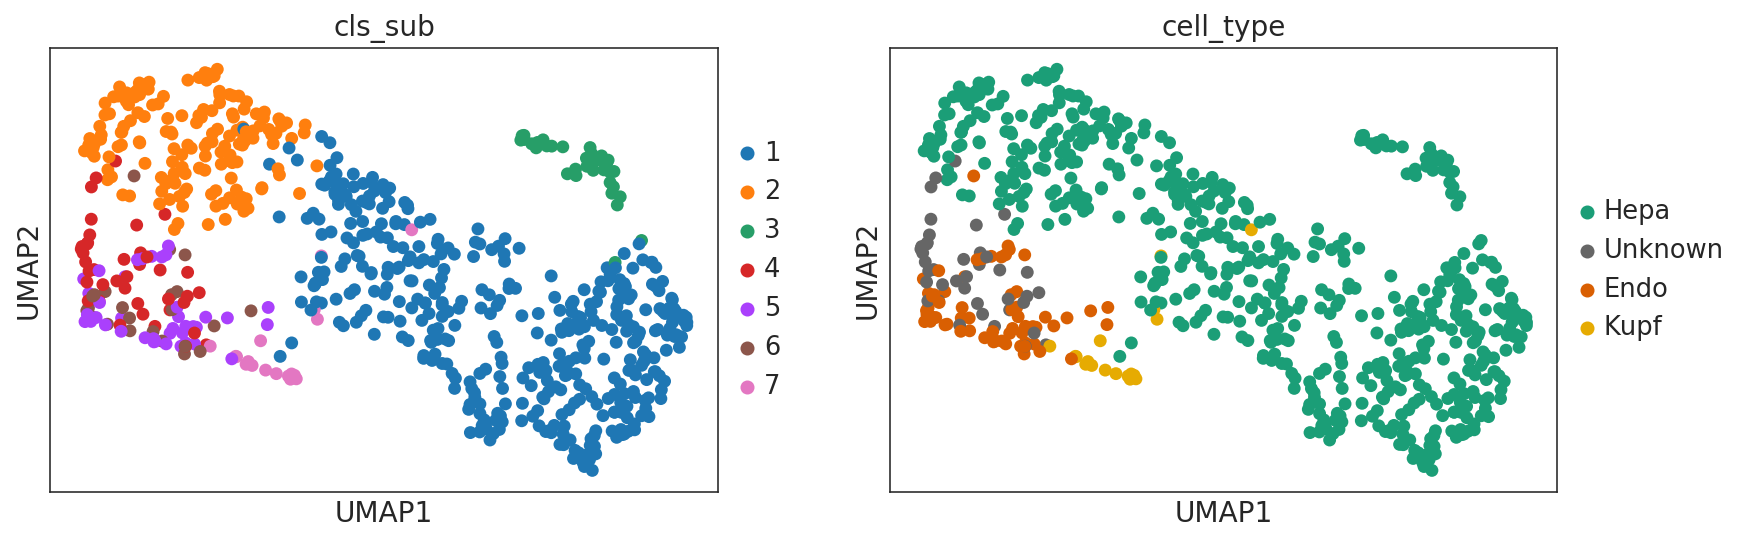

In [261]:
sc.pl.umap(a,color=['cls_sub','cell_type'])

In [267]:
1+1

2

In [264]:
np.sum(a.obs['cell_type']=='Hepa')

603

In [210]:
sc.tl.rank_genes_groups(a,groupby='cls_sub')

ranking genes
    finished (0:00:00)


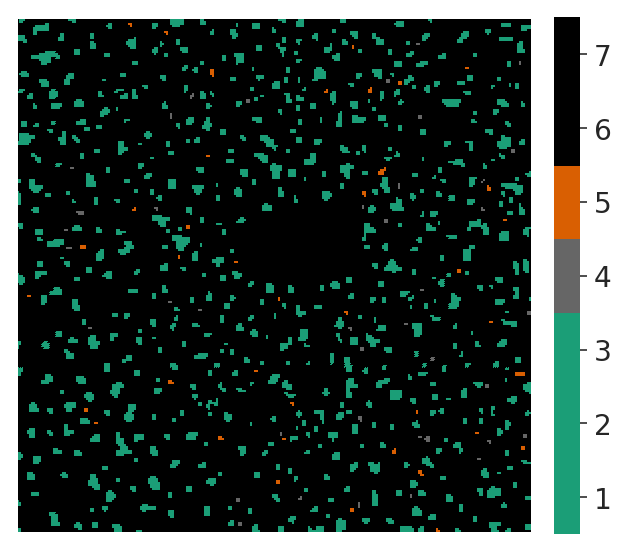

In [230]:
plot_label_image(a.obs['cls_sub_celltype'],a.uns['cls_sub_celltype_colors'],mask=[0,1,2,3,4],save=None)


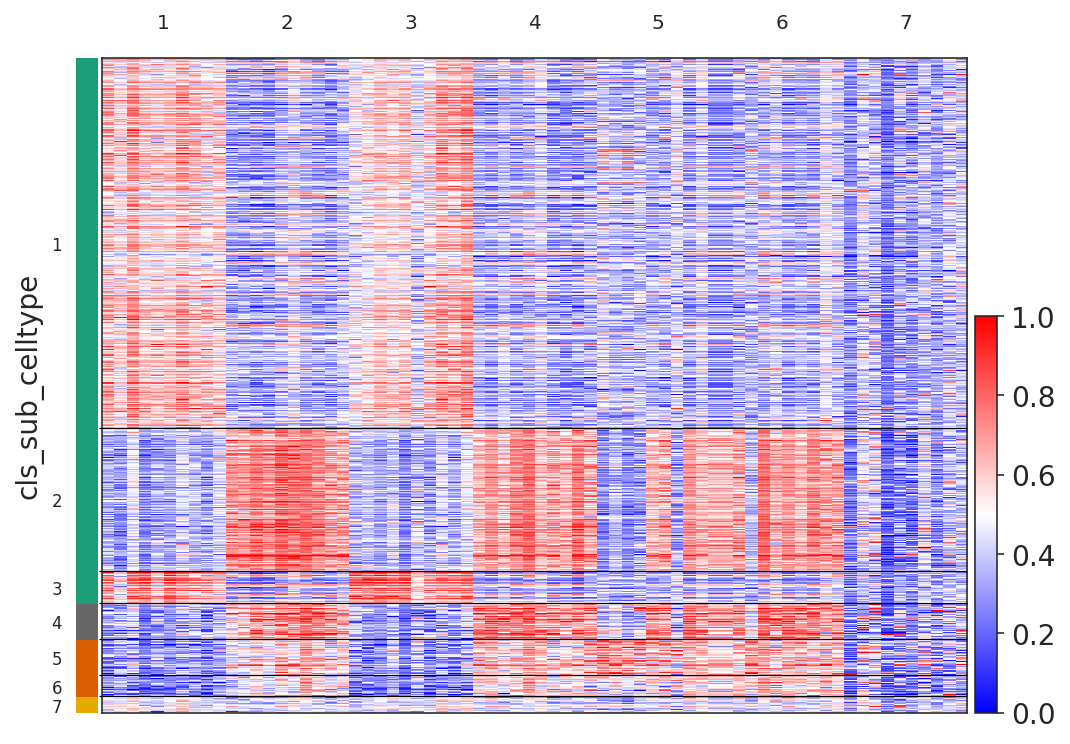

In [224]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_sub_celltype',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


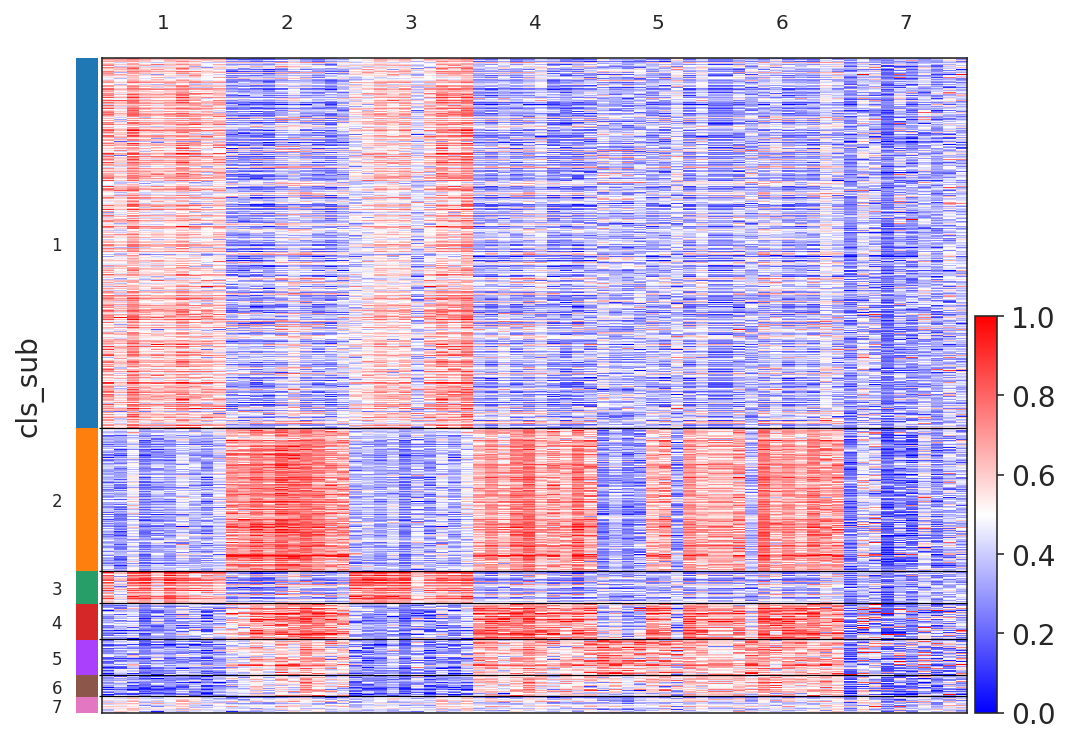

In [211]:
sc.pl.rank_genes_groups_heatmap(a,groupby='cls_sub',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

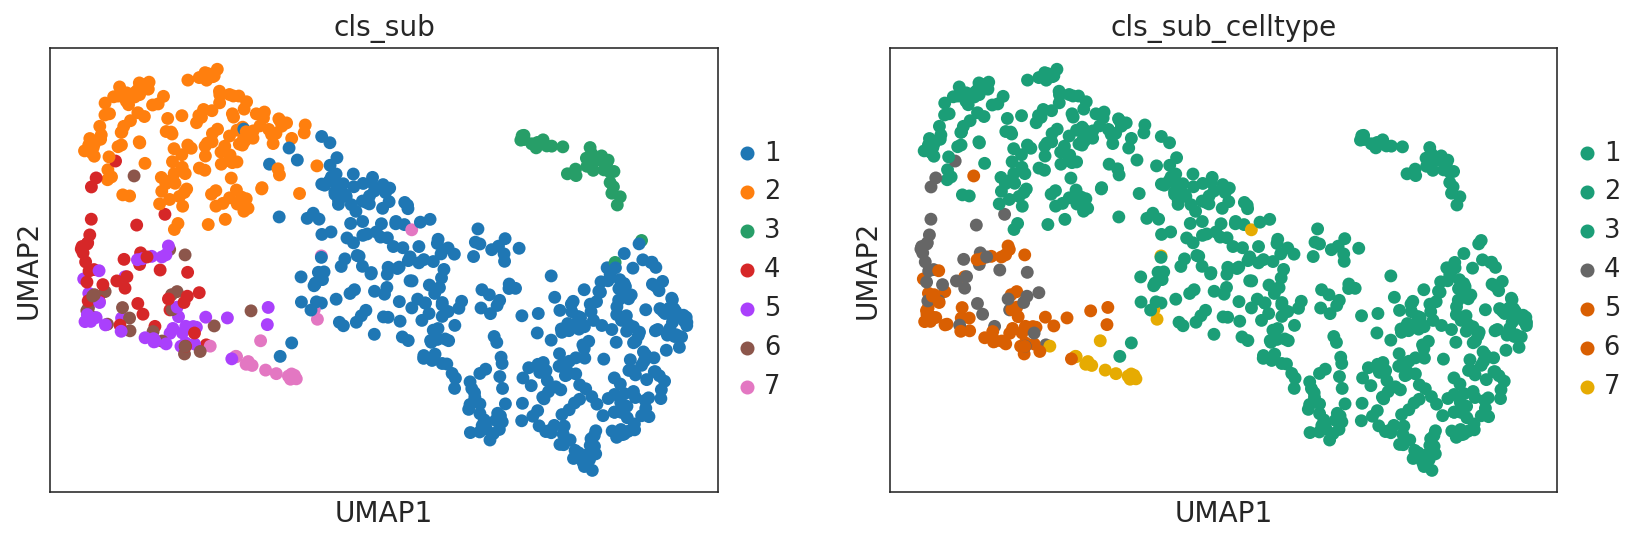

In [231]:
sc.pl.umap(a,color=['cls_sub','cls_sub_celltype'])

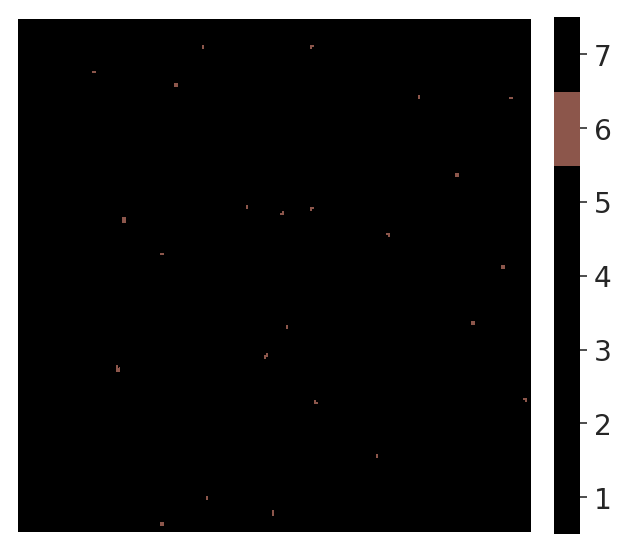

In [202]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[5],save=None)


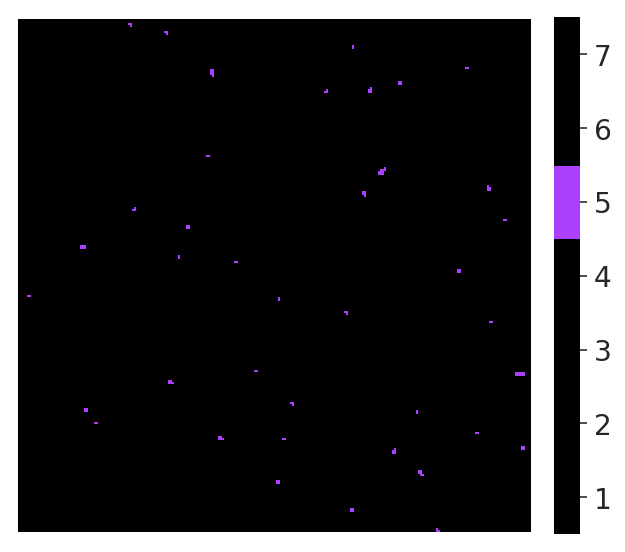

In [208]:
plot_label_image(a.obs['cls_sub'],a.uns['cls_sub_colors'],mask=[4],save=None)


## Different k

### annotation

In [370]:
cls_annotation = np.zeros(shape=(a.shape[0],))
endo_anno = [677,648,683,597,535,418,296,227,176,177]
kuf_anno = [627,604,565,499,447,333,301,252,206]
cls_annotation[endo_anno]=1
cls_annotation[kuf_anno] = 2
a.obs['annotation'] = cls_annotation.astype('int')
a.obs['annotation'] =a.obs['annotation'].astype('category')

### k=4

In [ ]:
a_cls_sub = np.array(a.obs['pred'])
ec_cls = np.array(a_ec.obs['louvain'])
to_replace_cls = '1'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

### k=5

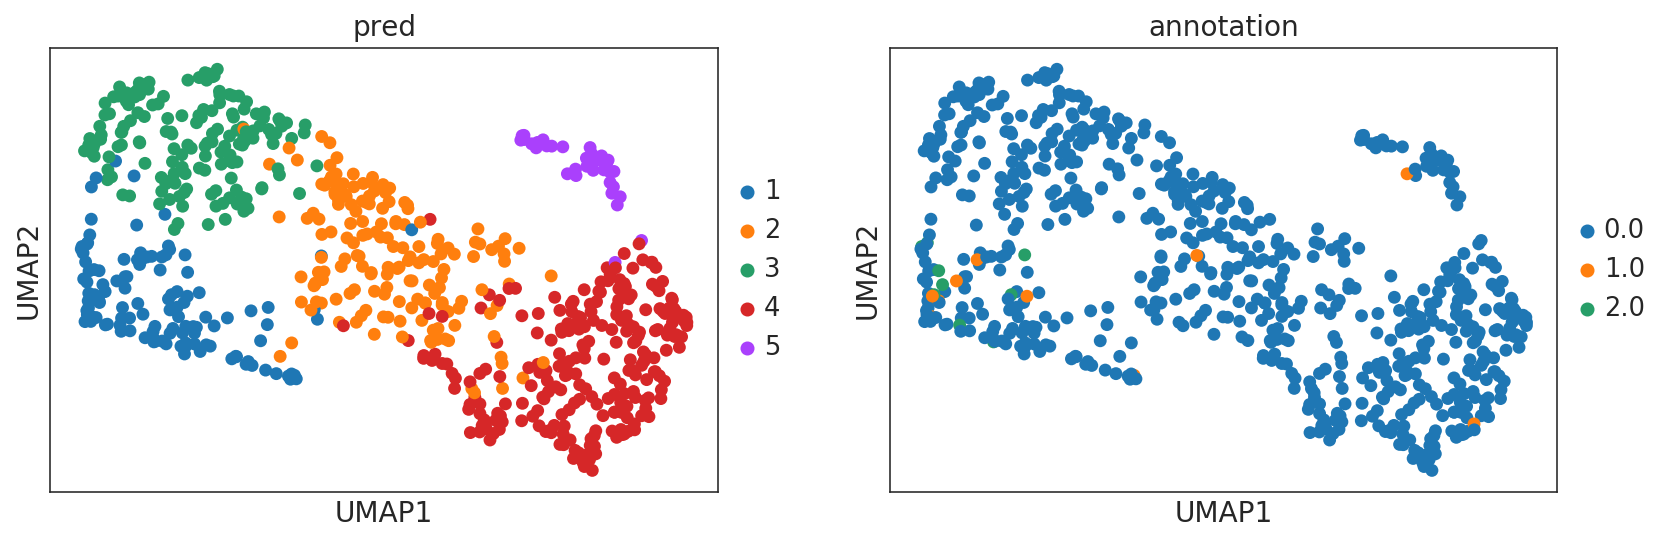

In [367]:
sc.pl.umap(a,color=['pred','annotation'])

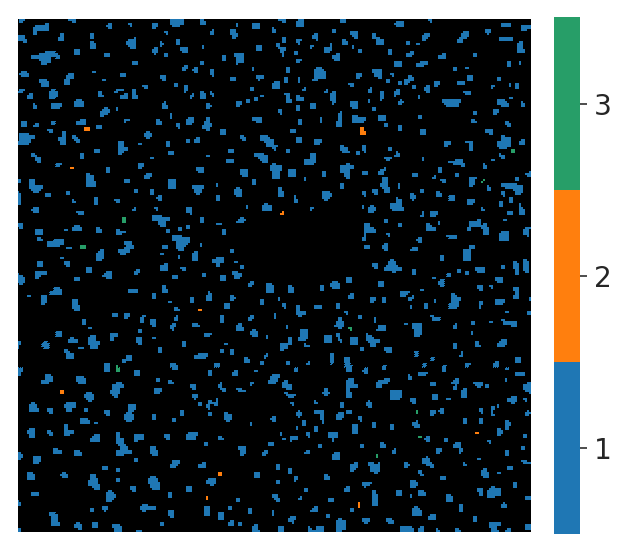

In [373]:
plot_label_image(a.obs['annotation'],a.uns['annotation_colors'],mask=None,save=None)


In [400]:
np.sum(a.obs['pred']=='2')

121

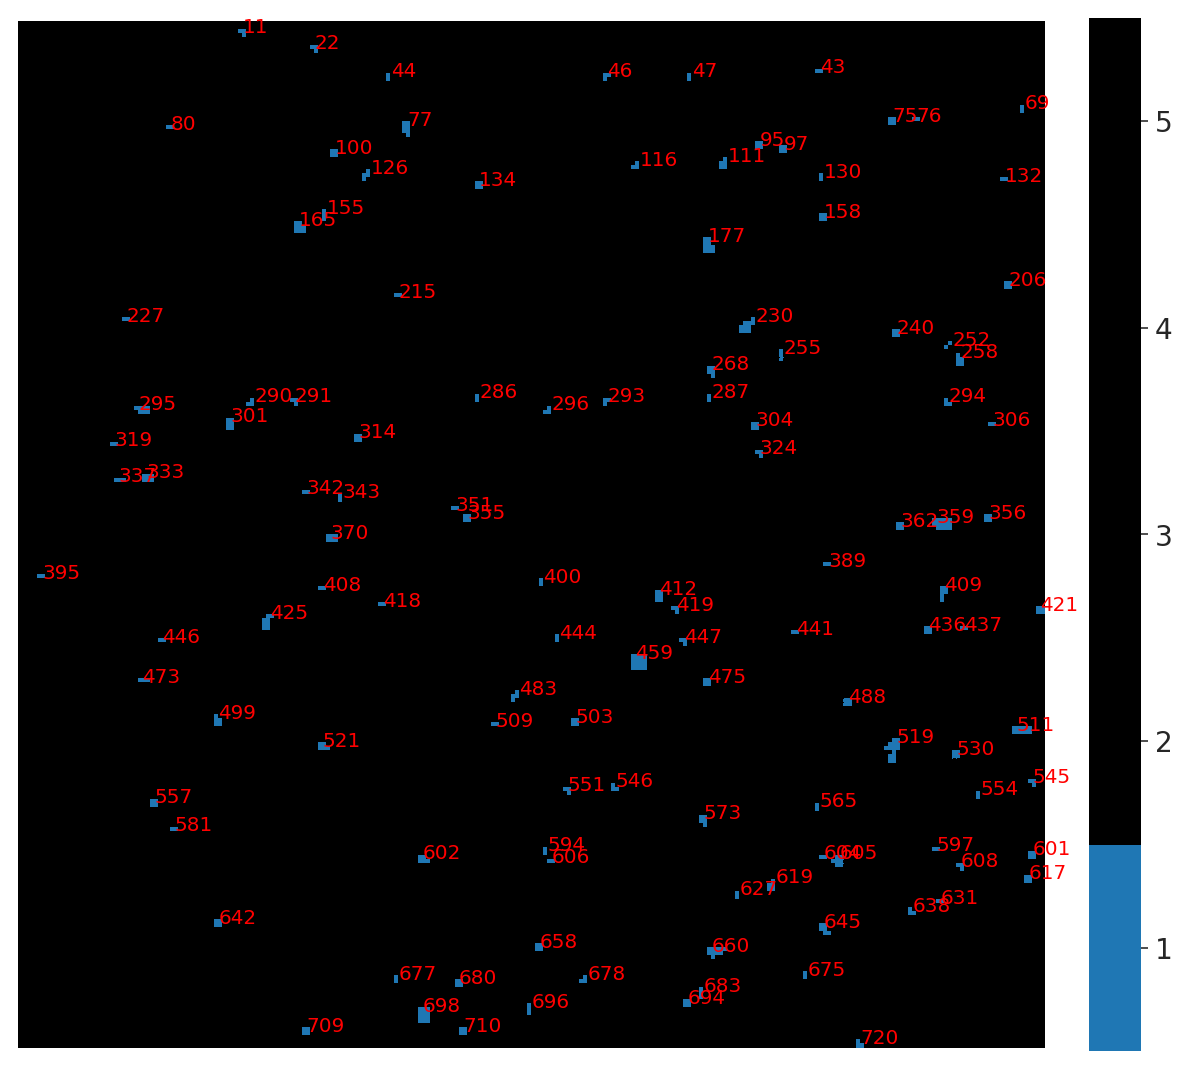

In [407]:
plot_label_image(a.obs['pred'],a.uns['pred_colors'],mask=[0],save=None,anno=1,figsize=(10,10))


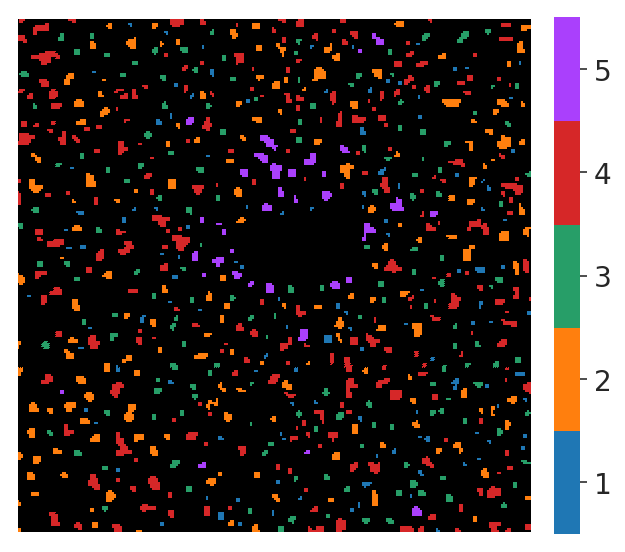

In [280]:
plot_label_image(a.obs['pred'],a.uns['pred_colors'],mask=None,save=None)


### k=6

In [305]:
a_ec2 = a[a.obs['pred']=='1']
sc.pp.neighbors(a_ec2)
sc.tl.louvain(a_ec2,resolution=0.4)
# 0.4:2
# 0.5:3
# 1:4

sc.pl.umap(a_ec2,color='louvain')

sc.tl.rank_genes_groups(a_ec2,groupby='louvain')

sc.pl.rank_genes_groups_heatmap(a_ec2,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


a_cls_sub = np.array(a.obs['pred'])
ec_cls = np.array(a_ec2.obs['louvain'])
to_replace_cls = '1'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

a.obs['cls_6'] = a_cls_sub_modified
a.obs['cls_6'] = a.obs['cls_6'].astype('category')

sc.pl.umap(a,color='cls_6')

In [340]:
sc.pp.neighbors(a_ec2)
sc.tl.louvain(a_ec2,resolution=0.4)
# 0.4:2
# 0.5:3
# 1:4

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


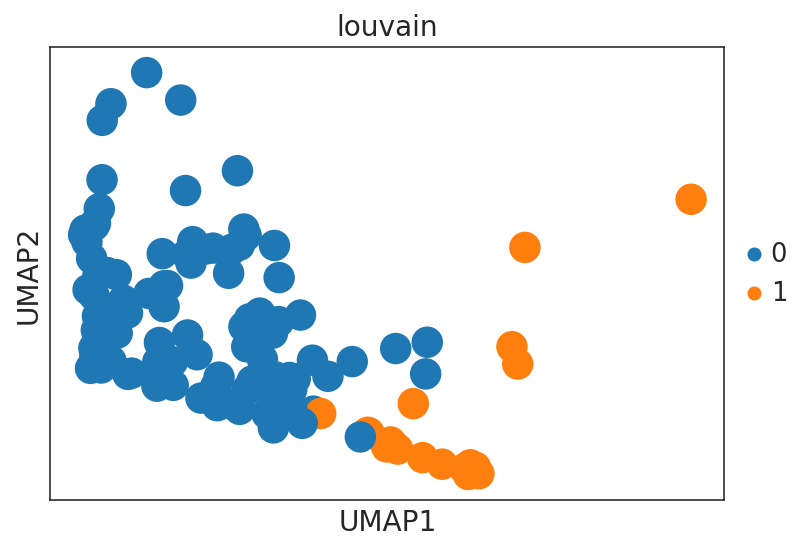

In [341]:
sc.pl.umap(a_ec2,color='louvain')

In [342]:
sc.tl.rank_genes_groups(a_ec2,groupby='louvain')

ranking genes
    finished (0:00:00)


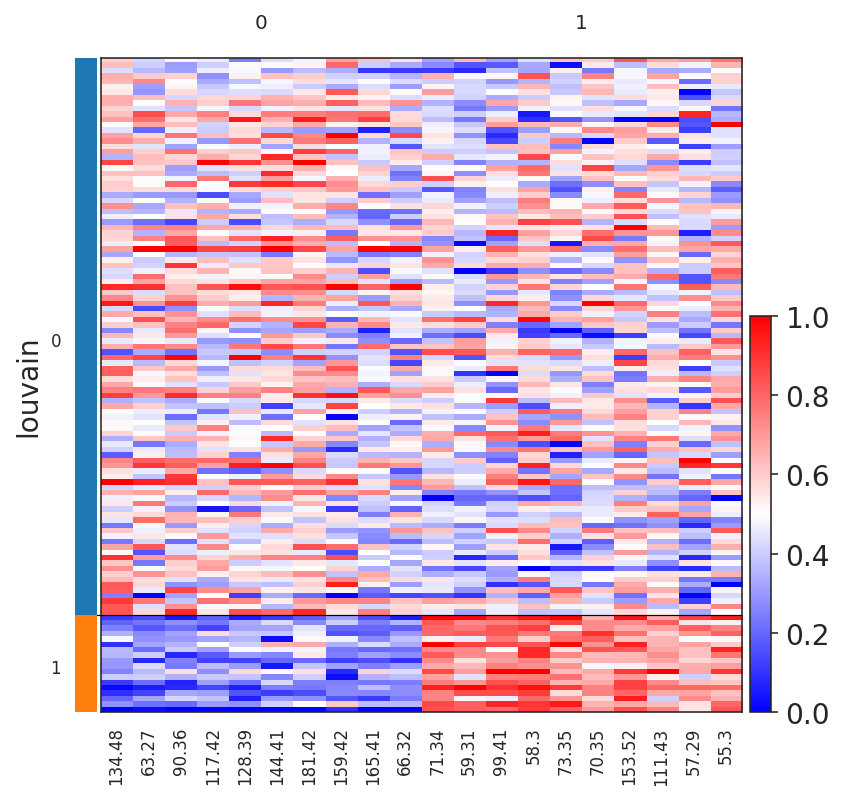

In [343]:
sc.pl.rank_genes_groups_heatmap(a_ec2,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


In [344]:
a_cls_sub = np.array(a.obs['pred'])
ec_cls = np.array(a_ec2.obs['louvain'])
to_replace_cls = '1'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

In [345]:
a.obs['cls_6'] = a_cls_sub_modified
a.obs['cls_6'] = a.obs['cls_6'].astype('category')

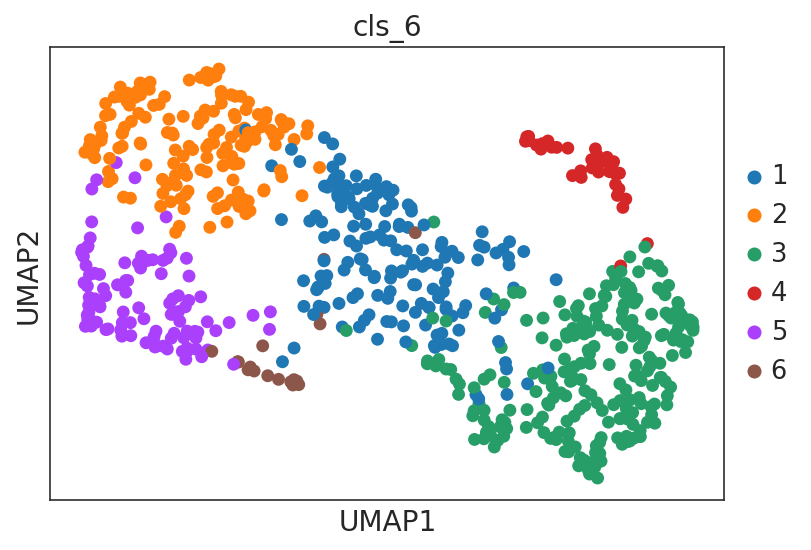

In [346]:
sc.pl.umap(a,color='cls_6')

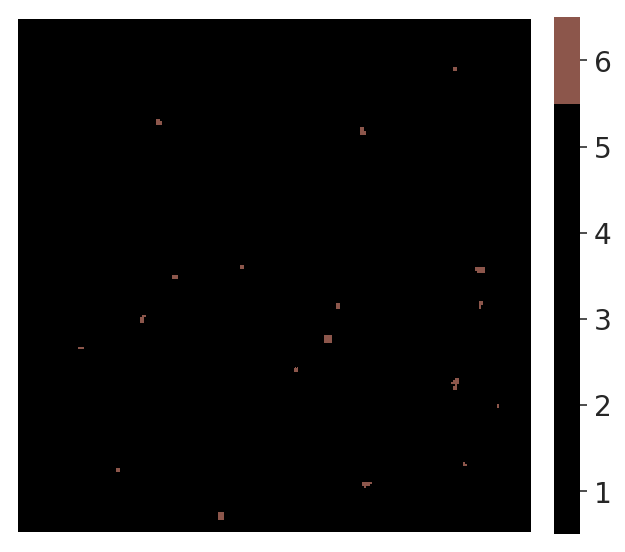

In [348]:
plot_label_image(a.obs['cls_6'],a.uns['cls_6_colors'],mask=[5],save=None)


### k=7

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


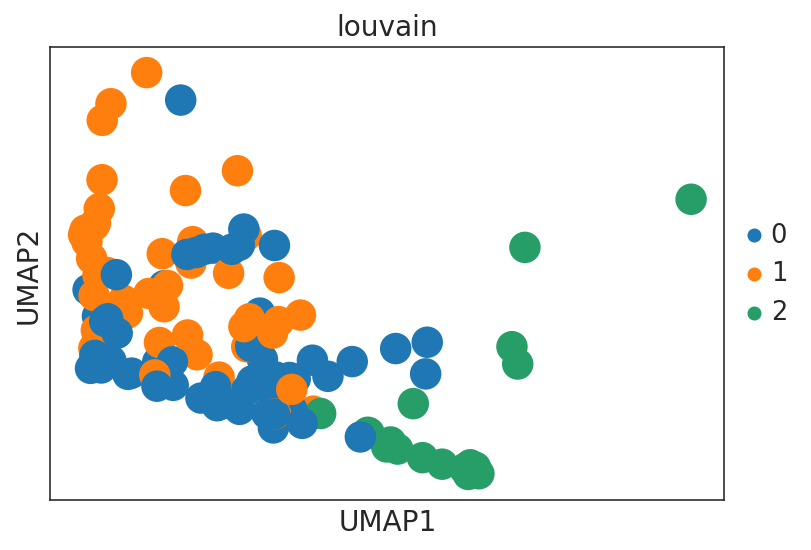

ranking genes
    finished (0:00:00)


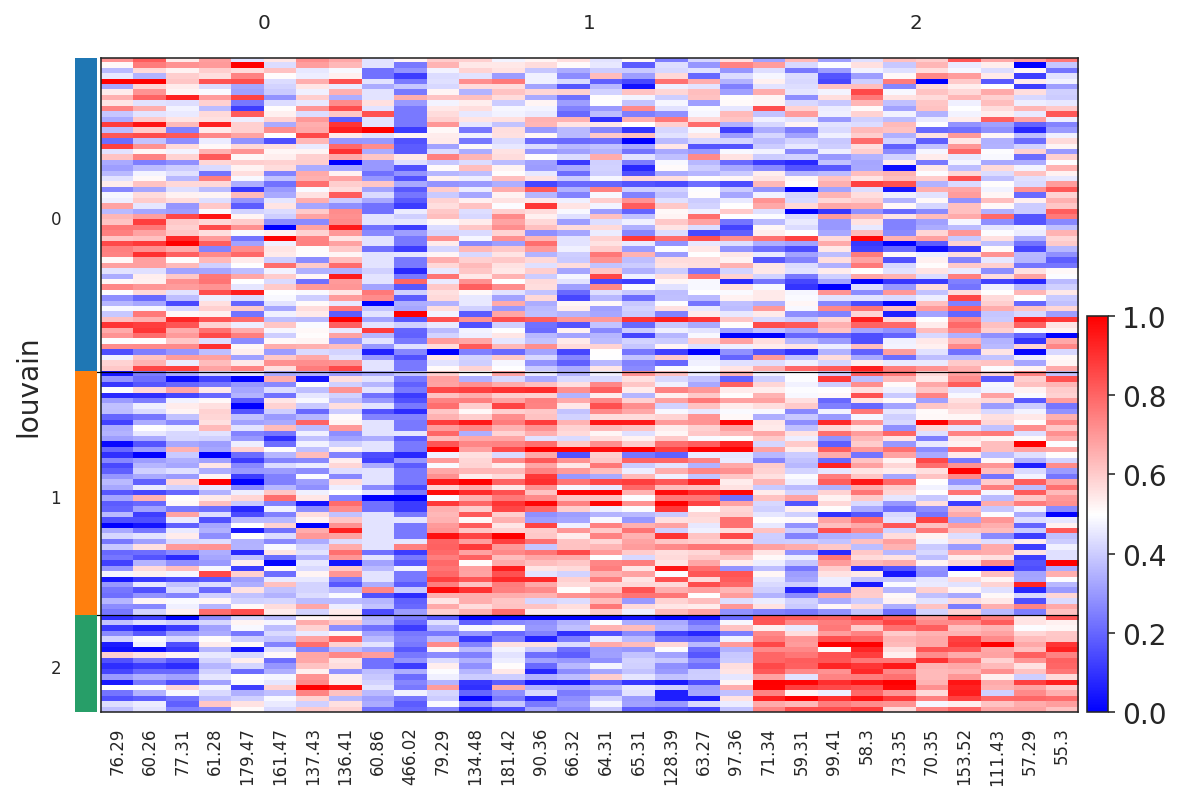

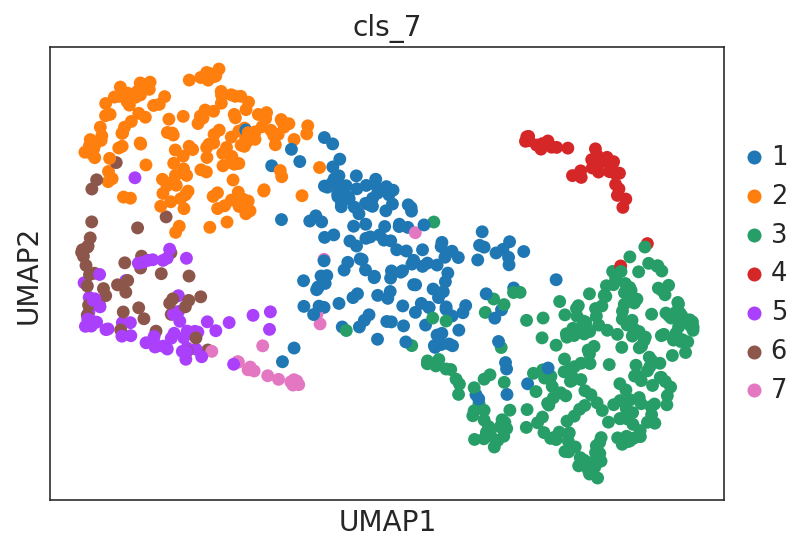

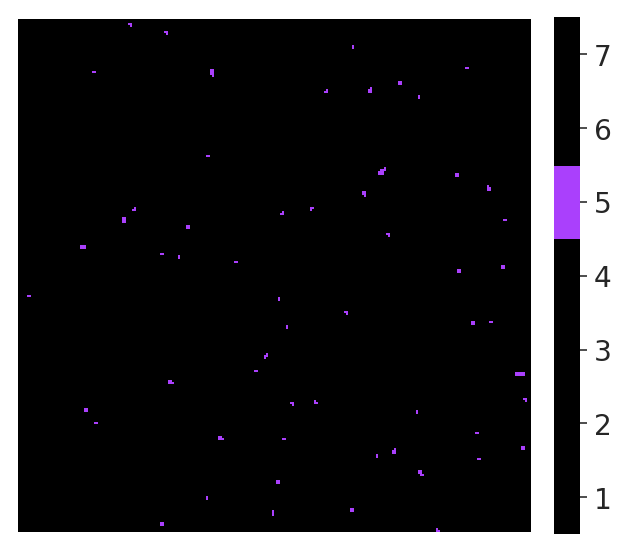

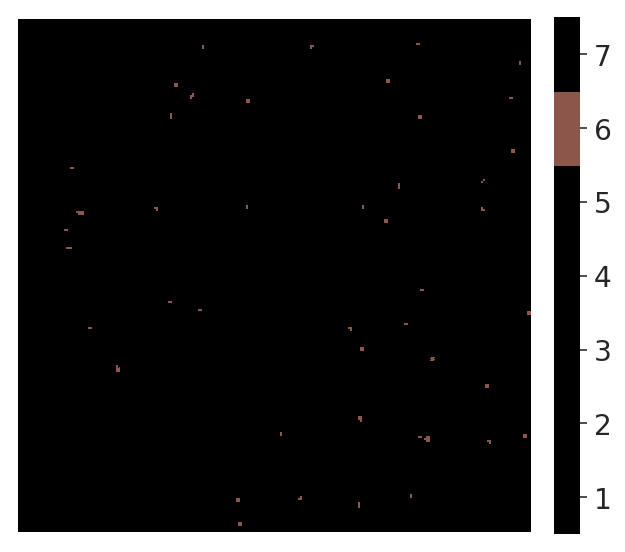

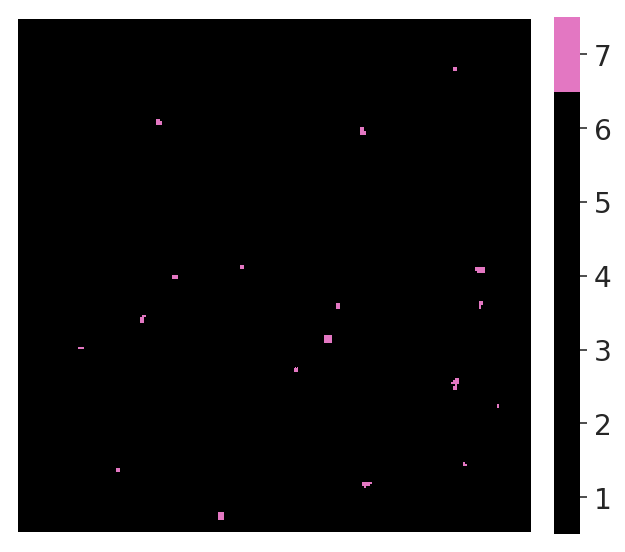

In [350]:
a_ec2 = a[a.obs['pred']=='1']
sc.pp.neighbors(a_ec2)
sc.tl.louvain(a_ec2,resolution=0.5)
# 0.4:2
# 0.5:3
# 1:4

sc.pl.umap(a_ec2,color='louvain')

sc.tl.rank_genes_groups(a_ec2,groupby='louvain')

sc.pl.rank_genes_groups_heatmap(a_ec2,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


a_cls_sub = np.array(a.obs['pred'])
ec_cls = np.array(a_ec2.obs['louvain'])
to_replace_cls = '1'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

a.obs['cls_7'] = a_cls_sub_modified
a.obs['cls_7'] = a.obs['cls_7'].astype('category')

sc.pl.umap(a,color='cls_7')

plot_label_image(a.obs['cls_7'],a.uns['cls_7_colors'],mask=[4],save=None)
plot_label_image(a.obs['cls_7'],a.uns['cls_7_colors'],mask=[5],save=None)
plot_label_image(a.obs['cls_7'],a.uns['cls_7_colors'],mask=[6],save=None)




### k=8

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


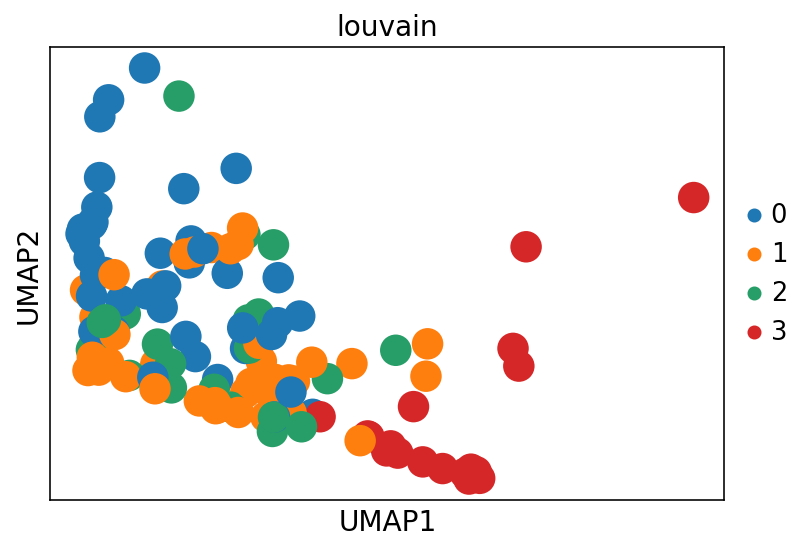

ranking genes
    finished (0:00:00)


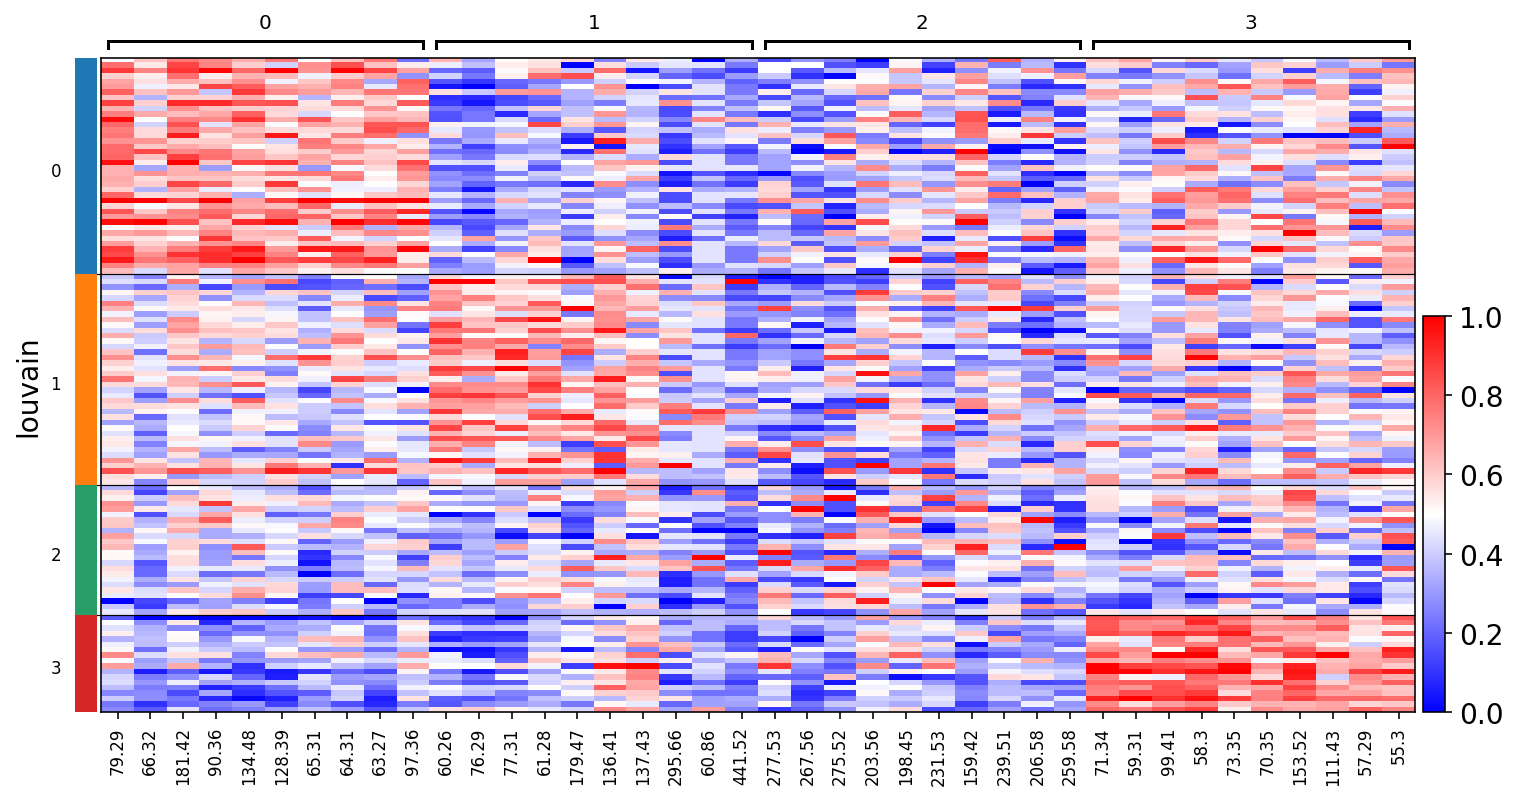

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

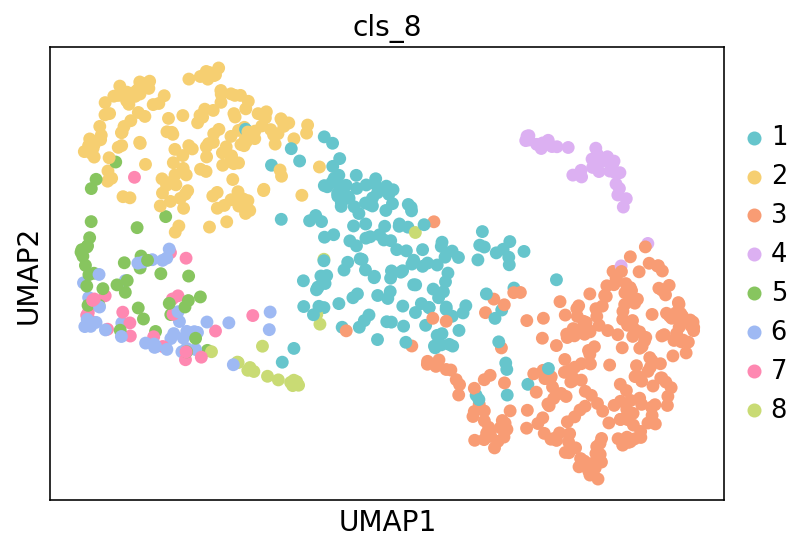

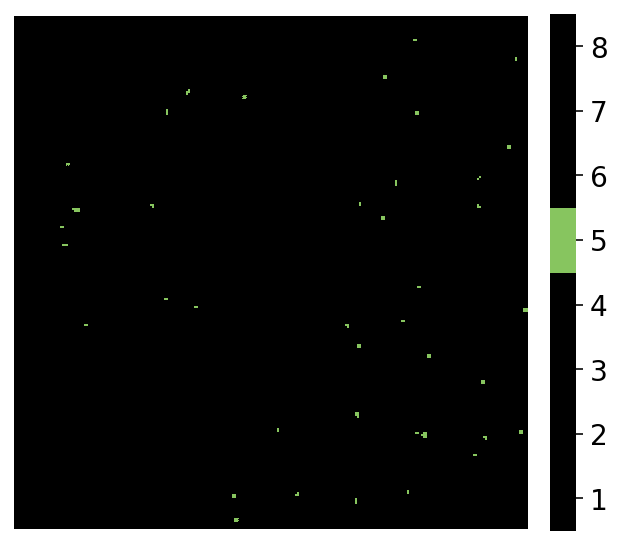

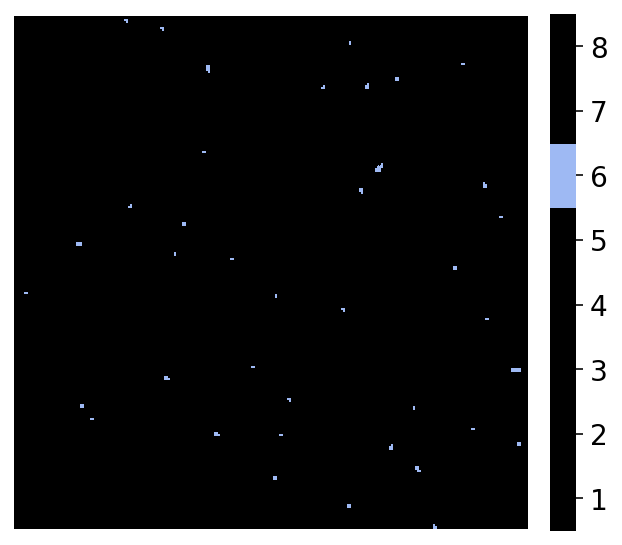

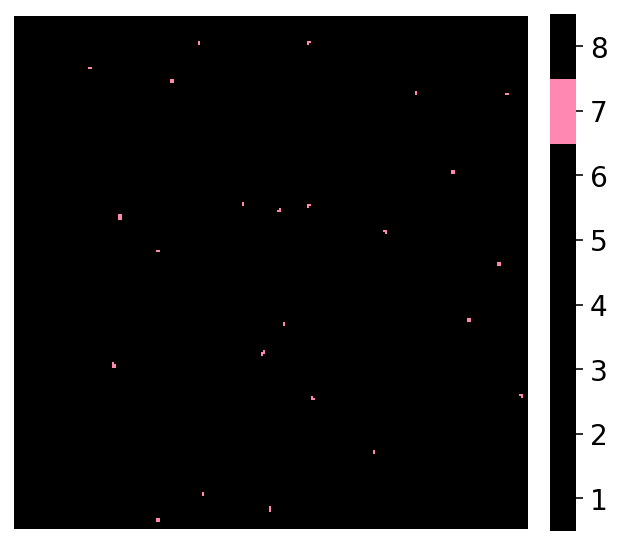

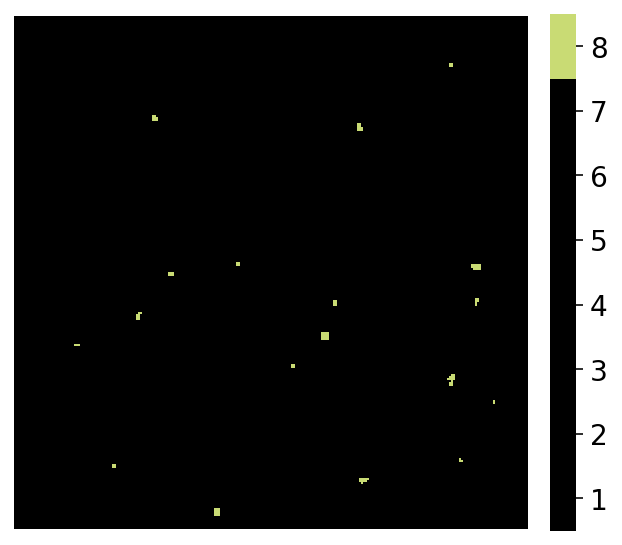

In [11]:
a_ec2 = a[a.obs['pred']=='1']

sc.pp.neighbors(a_ec2)
sc.tl.louvain(a_ec2,resolution=1)
# 0.4:2
# 0.5:3
# 1:4

sc.pl.umap(a_ec2,color='louvain')

sc.tl.rank_genes_groups(a_ec2,groupby='louvain')

sc.pl.rank_genes_groups_heatmap(a_ec2,groupby='louvain',standard_scale='var', cmap='bwr',dendrogram=False,save=None)


a_cls_sub = np.array(a.obs['pred'])
ec_cls = np.array(a_ec2.obs['louvain'])
to_replace_cls = '1'
a_cls_sub_modified = add_subcls(a_cls_sub,ec_cls,to_replace_cls)

a.obs['cls_8'] = a_cls_sub_modified
a.obs['cls_8'] = a.obs['cls_8'].astype('category')
a.uns['cls_8_colors'] = palettable.cartocolors.qualitative.Pastel_8.mpl_colors

sc.pl.umap(a,color='cls_8')

plot_label_image(a.obs['cls_8'],a.uns['cls_8_colors'],mask=[4],save=None)
plot_label_image(a.obs['cls_8'],a.uns['cls_8_colors'],mask=[5],save=None)
plot_label_image(a.obs['cls_8'],a.uns['cls_8_colors'],mask=[6],save=None)
plot_label_image(a.obs['cls_8'],a.uns['cls_8_colors'],mask=[7],save=None)




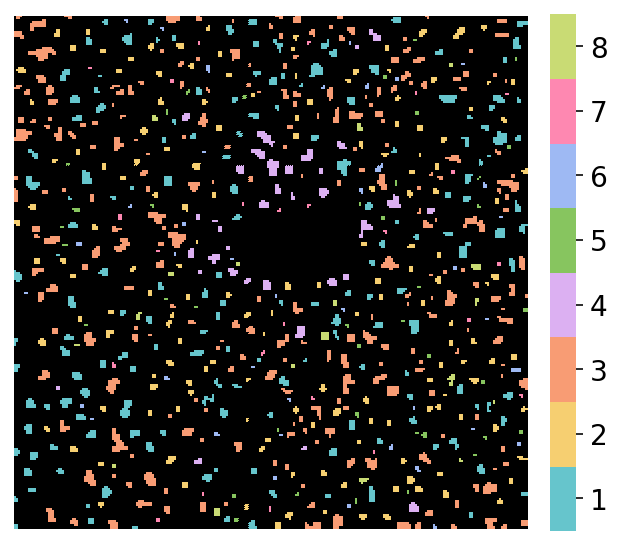

In [12]:

plot_label_image(a.obs['cls_8'],a.uns['cls_8_colors'],mask=[0,1,2,3,4,5,6,7],save=None)


In [416]:
a_filter = a[a.obs['cls_8']!='8']

In [13]:
a.shape

(724, 244)

In [475]:
sc.tl.rank_genes_groups(a,groupby='cls_8',method='t-test',reference='5')

ranking genes
    finished (0:00:00)


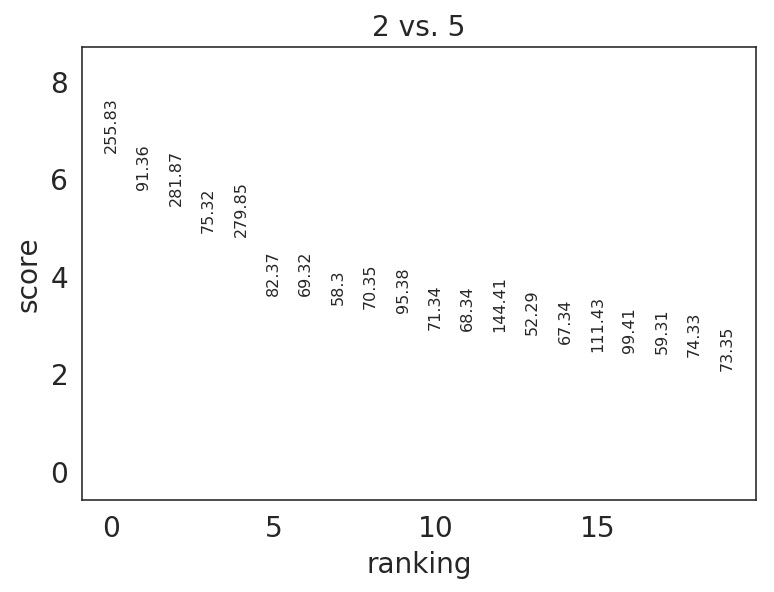

In [476]:
sc.pl.rank_genes_groups(a,groups='2')

In [487]:
# 3 vs 1:91.36,75.32,66.32,65.31
# 1 vs 3:60.26,77.31,137.43,76.29

marker_list =[
    #     EC:
    60.26,77.31,61.28,62.29,76.29,
    
    #     IC
    181.42,144.41,128.39,91.36,75.32,
    

#     Hepa
    253.79,255.83,281.87,
    #     Hepa87+
#     221.56,87.36,101.41,59.31,71.34,
    58.30,59.31,71.34,101.41,69.32,87.36


]
marker_list = np.array(marker_list).astype('str')

In [456]:
# 类顺序：6，7，5，2，1，3，4，8

Index(['50.27', '50.83', '51.29', '52.29', '53.29', '54.32', '55.3', '56.31',
       '57.29', '58.3',
       ...
       '409.57', '419.54', '425.58', '439.56', '441.52', '443.57', '447.59',
       '457.52', '466.02', '487.6'],
      dtype='object', name='index', length=244)

In [14]:
a.obs['cls_8_reorder'] = a.obs['cls_8']

In [499]:
a.uns['cls_8_reorder_colors'] = a.uns['cls_8_colors']

In [464]:
a.obs.cls_8_reorder.cat.reorder_categories(['8','6','7','5','2','1','3','4'], inplace=True) 


In [511]:
# Hepa:1,2,3,4
# Endo:6,7
# Kupf:5
# Other:8
a_cls8 = np.array(a.obs['cls_8_reorder'])
a_celltype = a_cls8.copy()
a_celltype[a_cls8=='1'] = "Other"
a_celltype[a_cls8=='2'] = "Endo"
a_celltype[a_cls8=='3'] = "Endo"
a_celltype[a_cls8=='4'] = "Kupf"

a_celltype[a_cls8=='5'] = "Hepa"
a_celltype[a_cls8=='6'] = "Hepa"
a_celltype[a_cls8=='7'] = "Hepa"
a_celltype[a_cls8=='8'] = "Hepa"

a.obs['celltype_cls8'] = a_celltype
a.obs['celltype_cls8'] = a.obs['celltype_cls8'].astype('category')

In [15]:
cls_8 = np.array(a.obs['cls_8']).astype('int')
cls_8_reorder = cls_8.copy()
cls_8_reorder[cls_8==8]=1
cls_8_reorder[cls_8==6]=2
cls_8_reorder[cls_8==7]=3
cls_8_reorder[cls_8==5]=4
cls_8_reorder[cls_8==2]=5
cls_8_reorder[cls_8==1]=6
cls_8_reorder[cls_8==3]=7
cls_8_reorder[cls_8==4]=8
a.obs['cls_8_reorder'] = cls_8_reorder.astype('str')
a.obs['cls_8_reorder'] = a.obs['cls_8_reorder'].astype('category')


In [16]:
cls_8_cmp = palettable.cartocolors.qualitative.Bold_8.mpl_colors
a.uns['cls_8_reorder_colors'] = cls_8_cmp.copy()
a.uns['cls_8_reorder_colors'][4] = cls_8_cmp[7]
a.uns['cls_8_reorder_colors'][7] = cls_8_cmp[4]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

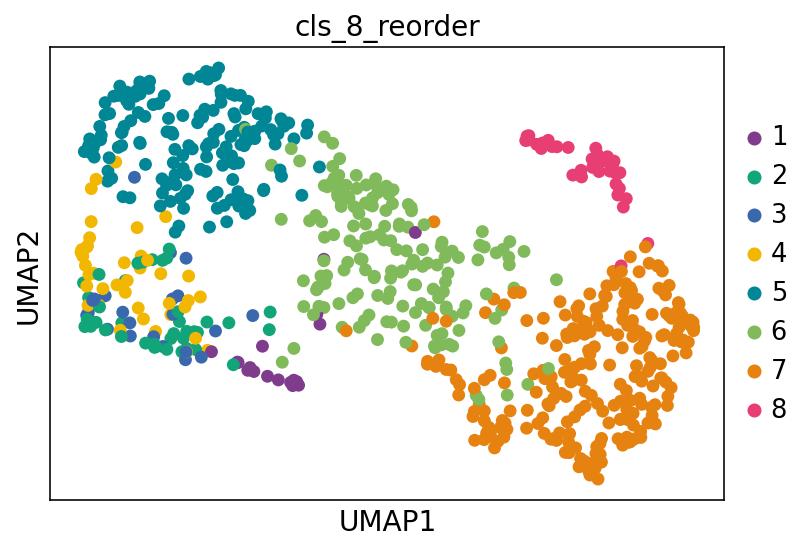

In [17]:
sc.pl.umap(a,color='cls_8_reorder')

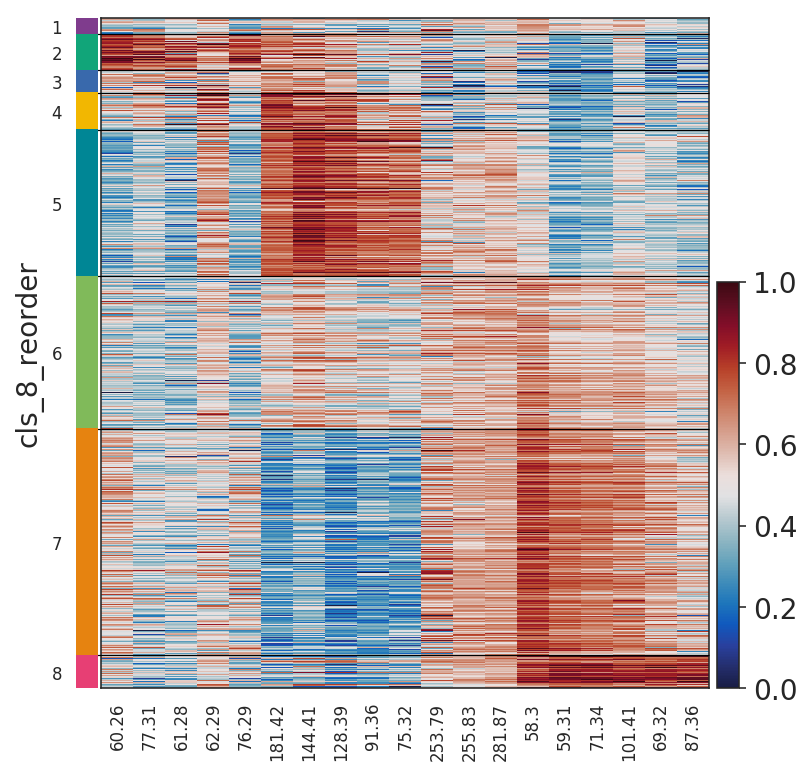

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 5.7, 0, 0.2])

In [525]:
sc.pl.heatmap(a,marker_list,groupby='cls_8_reorder',standard_scale='var', cmap=heatmap_cmp,
              dendrogram=False,save=None,log=True)


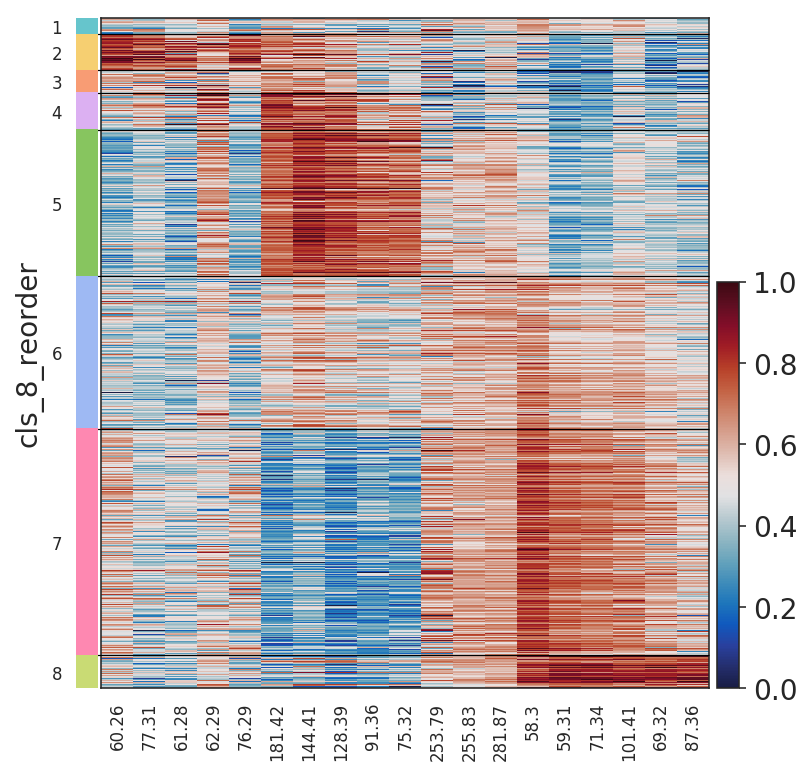

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 5.7, 0, 0.2])

In [509]:
sc.pl.heatmap(a,marker_list,groupby='cls_8_reorder',standard_scale='var', cmap=heatmap_cmp,
              dendrogram=False,save=None,log=True)


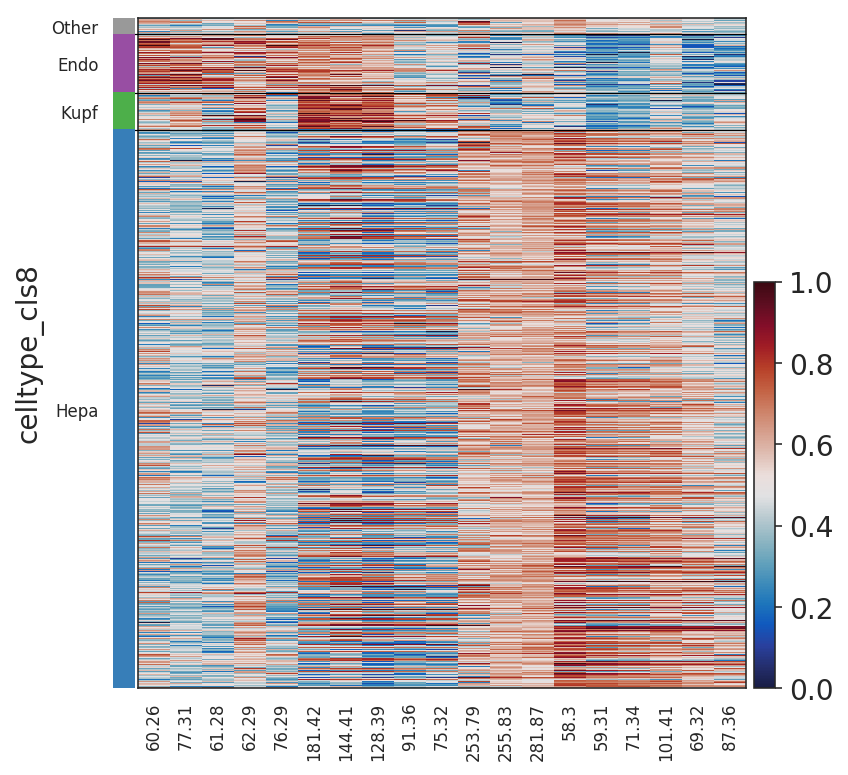

GridSpec(2, 4, height_ratios=[0, 6], width_ratios=[0.2, 5.7, 0, 0.2])

In [513]:
a.obs.celltype_cls8.cat.reorder_categories(['Other','Endo','Kupf','Hepa'], inplace=True) 

celltype_cmp = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
# Endo:紫
# Hepa:蓝
# Kupf：绿
# Other:灰
# Fibr:粉

a.uns['celltype_cls8_colors'] = [celltype_cmp[8],celltype_cmp[3],celltype_cmp[2],celltype_cmp[1]]
sc.pl.heatmap(a,marker_list,groupby='celltype_cls8',standard_scale='var', cmap=heatmap_cmp,
              dendrogram=False,save=None,log=True)


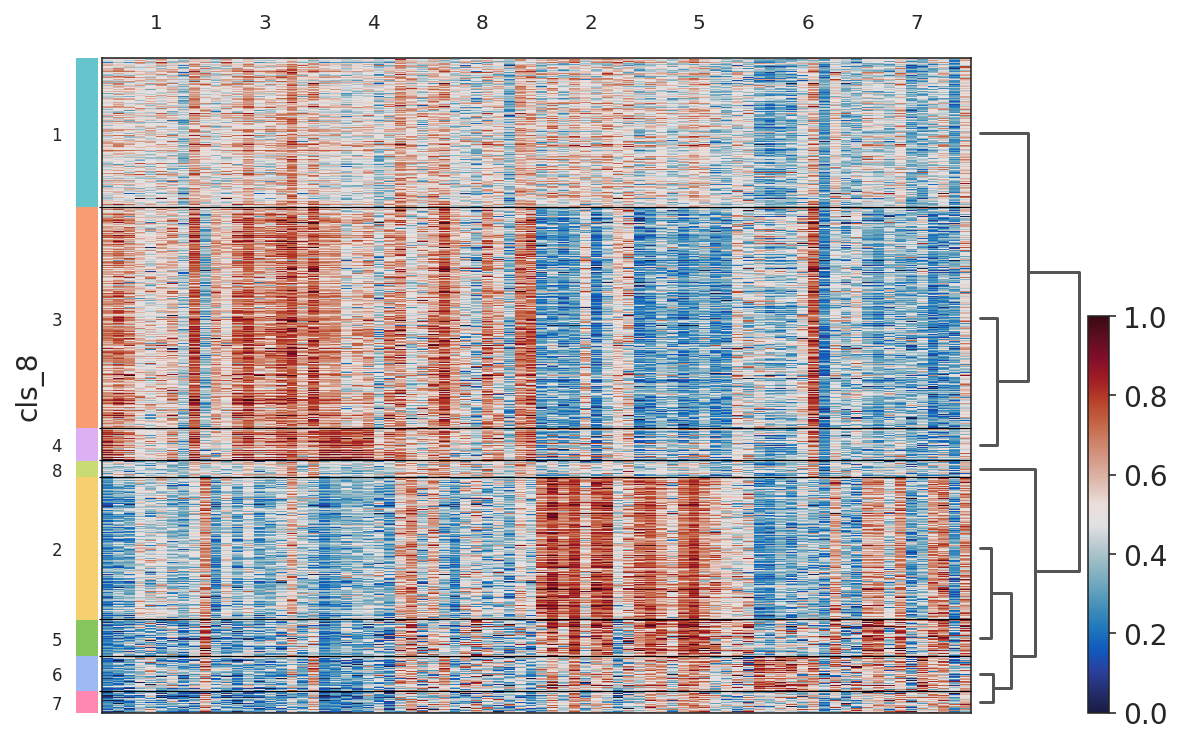

In [445]:
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap
sc.pl.rank_genes_groups_heatmap(a,n_genes=10,groupby='cls_8',standard_scale='var', cmap=heatmap_cmp,dendrogram=True,save=None)


In [408]:
np.unique(a.obs['cls_8'],return_counts=1)

(array(['1', '2', '3', '4', '5', '6', '7', '8'], dtype=object),
 array([165, 158, 244,  36,  40,  39,  24,  18]))

In [375]:
a.obs['cls_5'] = a.obs['pred']


In [395]:
k_list = [5,6,7]
endo_idx = np.where(np.array(a.obs['annotation'])==1)
kuf_idx = np.where(np.array(a.obs['annotation'])==2)

for k in k_list:
    cur_pred = a.obs['cls_'+str(k)]
    endo_com = np.array(cur_pred)[endo_idx]
    kuf_com = np.array(cur_pred)[kuf_idx]

In [396]:
kuf_com

array(['6', '6', '5', '5', '6', '6', '5', '6', '5'], dtype=object)

In [397]:
endo_com

array(['3', '7', '6', '5', '6', '4', '5', '1', '5', '6'], dtype=object)

In [388]:
np.array(cur_pred)[endo_idx]

array(['3', '8', '5', '7', '5', '4', '6', '1', '7', '5'], dtype=object)

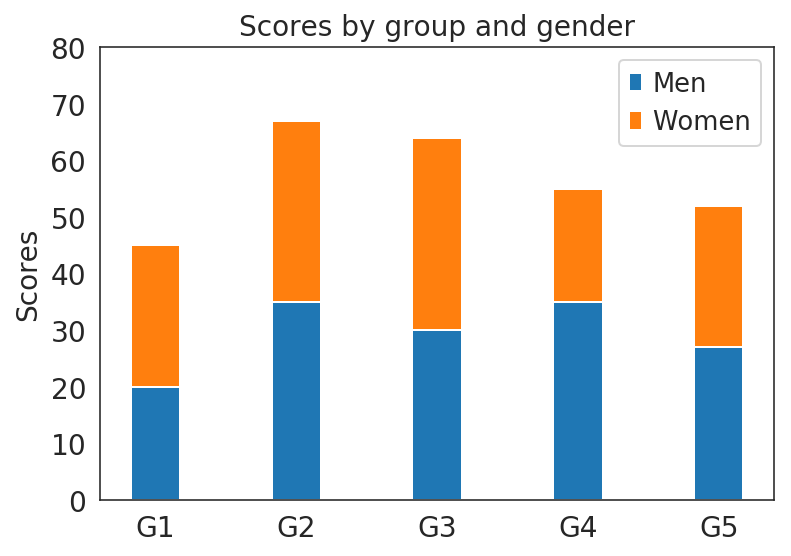

In [391]:
import numpy as np
import matplotlib.pyplot as plt


N = 5
menMeans = (20, 35, 30, 35, 27)
womenMeans = (25, 32, 34, 20, 25)
menStd = (2, 3, 4, 1, 2)
womenStd = (3, 5, 2, 3, 3)
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, menMeans, width)
p2 = plt.bar(ind, womenMeans, width,
             bottom=menMeans)

plt.ylabel('Scores')
plt.title('Scores by group and gender')
plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('Men', 'Women'))

plt.show()

# save anndata

In [140]:
# a.write('figures/Fig2/c5/fig2_c4.h5py')

In [12]:
a.write('figures/Fig2_dump_data/fig2_c5_addspatial.h5ad')